In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat, savemat
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit, minimize, least_squares
from scipy.integrate import trapz
from scipy.stats import norm, kurtosis
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

In [2]:
#axes.xaxis.set_tick_params(direction='in', which='both')
#axes.yaxis.set_tick_params(direction='in', which='both')



mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
#c('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')
def cm2inch(value):
    return value/2.54

In [5]:
raw_data = loadmat('data_sim.mat')
#raw_data = raw_data[45000:,:]
#raw_data = raw_data[1:,:]

r = 1.5*1e-6
n_part =  1.597
fps = 100
time = np.arange(len(np.squeeze(raw_data["x"])))/fps


# Data exploration


In [6]:
dataset = {} # Dataset where we will store the different fitted data in order to fit everything at the end
dataset["r"] = r
dataset["n"] = n_part
dataset["time"] = time
dataset["fps"] = 100

In [8]:
#raw_data[:,2][raw_data[:,2] < 9.8] = np.nan # 

In [22]:
# We put everything in microns

x = np.squeeze(raw_data["x"])*1e6
y = np.squeeze(raw_data["y"])*1e6
z = np.squeeze(raw_data["z"])*1e6



Text(0, 0.5, 'z [$\\mathrm{\\mu m}$]')

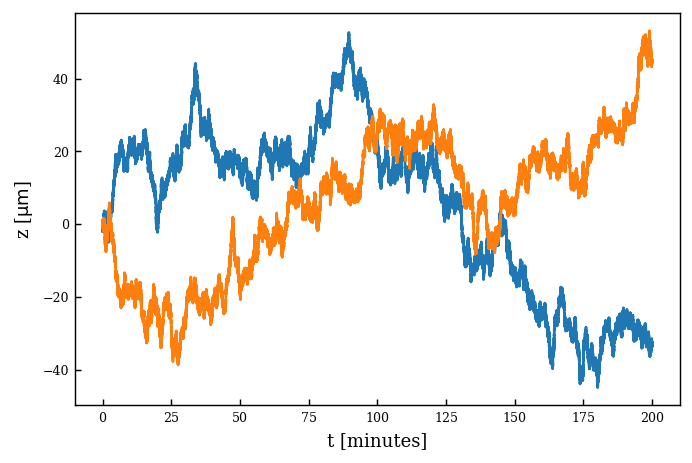

In [23]:
plt.plot(time/100, x)
plt.plot(time/100, y)
plt.xlabel("t [minutes]")
plt.ylabel("z [$\mathrm{\mu m}$]")

In [24]:
#N = 2000
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.ticklabel_format(style = "sci")
#for i in range(N-1):
#    ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.jet(1*i/N))
    
#plt.xlabel("x [$\mathrm{\mu m}$]")
#plt.xlabel("y [$\mathrm{\mu m}$]")
#plt.xlabel("z [$\mathrm{\mu m}$]")

In [25]:
def MSD(x, t):
    MSD = np.zeros(len(t))
    for n,i in enumerate(t):
        MSD[n] = np.nanmean((x[0:-i] - x[i:]) ** 2)
    return MSD

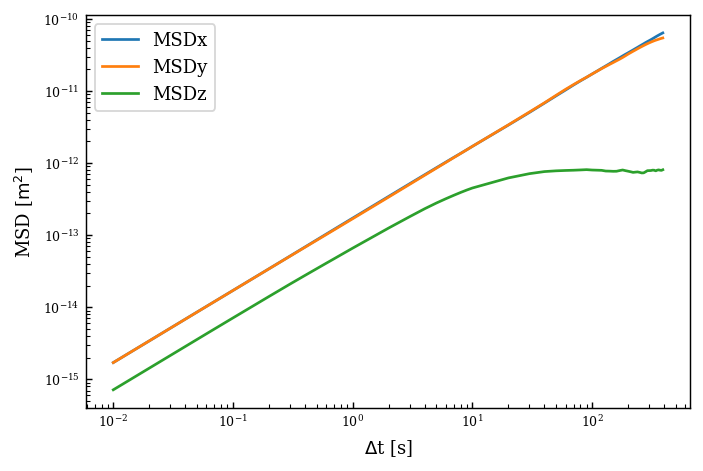

In [26]:
t = np.concatenate((np.arange(1,10, 1),np.arange(10,100, 10), np.arange(100,1000, 100),np.arange(1000,40000, 1000)))
MSD_x = MSD(x*1e-6, t) # m² conversion
MSD_y = MSD(y*1e-6, t)
MSD_z = MSD(z*1e-6, t)


plt.loglog(time[t],MSD_x, label = "MSDx")
plt.plot(time[t],MSD_y, label = "MSDy")
plt.plot(time[t],MSD_z, label = "MSDz")
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")

plt.legend()

dataset["MSD_x_tot"] = MSD_x
dataset["MSD_y_tot"] = MSD_y
dataset["MSD_z_tot"] = MSD_z
dataset["MSD_time_tot"] = time[t]



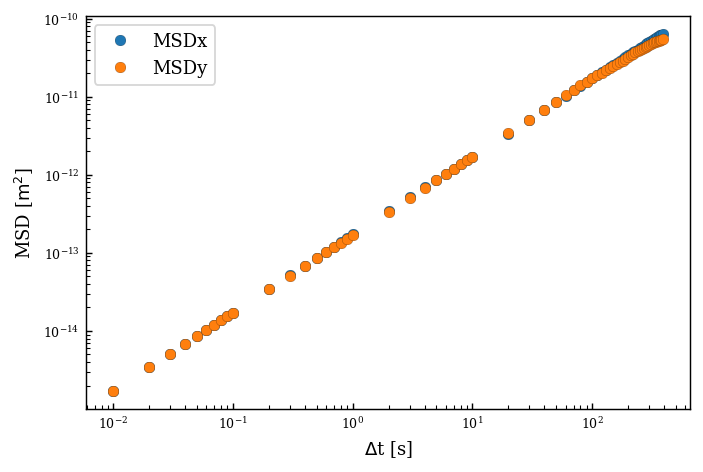

In [27]:
plt.loglog(time[t],MSD_x, "o", label = "MSDx")
plt.plot(time[t],MSD_y, "o", label = "MSDy")
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")
plt.legend()

Text(0.5, 0, '$\\Delta$t [s]')

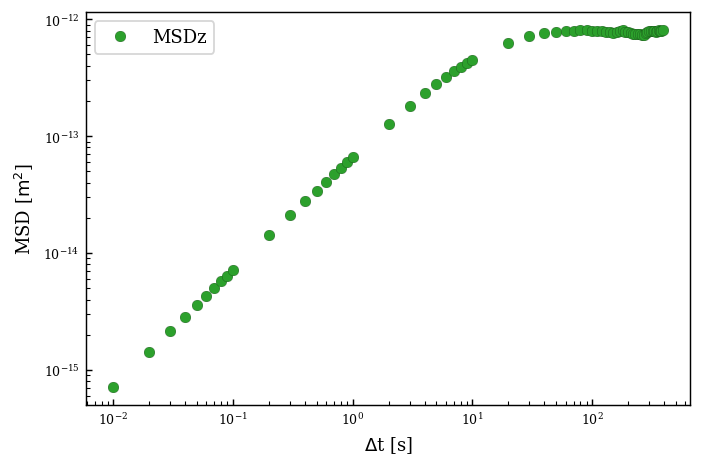

In [28]:
plt.loglog(time[t],MSD_z,"o", label = "MSDz", color = "tab:green")
plt.legend()
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")

In [29]:
Do = 4e-21/(6 * np.pi * 0.001 * r)
f = lambda x,a,noiselevel : 2 * Do * a * x + (noiselevel * 1e-9) ** 2
popt_1 , pcov_1 = curve_fit(f,time[t[0:5]],MSD_x[0:5], p0 = [1, 30])
popt_2 , pcov_1 = curve_fit(f,time[t[0:5]],MSD_y[0:5], p0 = [1, 30])
popt_3 , pcov_1 = curve_fit(f,time[t[0:5]],MSD_z[0:5], p0 = [1, 30])

dataset["x_MSD_fit"] = time[t[0:5]]

dataset["MSD_x"] = MSD_x[0:5]
dataset["MSD_y"] = MSD_y[0:5]
dataset["MSD_z"] = MSD_z[0:5]

C:\Users\maxim\miniconda3\envs\cython\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0, '$\\Delta$t [s]')

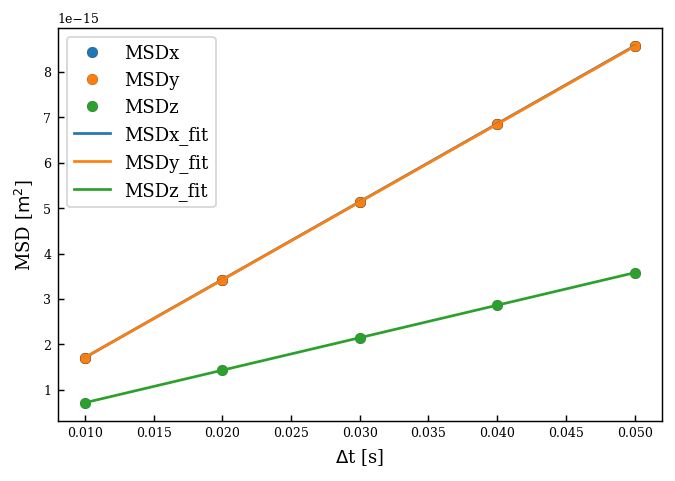

In [30]:
plt.plot(time[t[0:5]],MSD_x[0:5],"o", label = "MSDx")
plt.plot(time[t[0:5]],MSD_y[0:5],"o", label = "MSDy")
plt.plot(time[t[0:5]],MSD_z[0:5],"o", label = "MSDz")

plt.plot(time[t[0:5]],f(time[t[0:5]], *popt_1), label = "MSDx_fit", color = "tab:blue")
plt.plot(time[t[0:5]],f(time[t[0:5]], *popt_2), label = "MSDy_fit", color = "tab:orange")
plt.plot(time[t[0:5]],f(time[t[0:5]], *popt_3), label = "MSDz_fit", color = "tab:green")


plt.legend()
plt.ylabel("MSD [$\mathrm{m^2}$]")
plt.xlabel("$\Delta$t [s]")

In [31]:
print("We measure a reduced mean diffusion coefficient of {:.3f} for the perpendicular motion and of {:.3f} for the parallel motion".format((popt_1[0]+popt_2[0])/2, popt_3[0]))

We measure a reduced mean diffusion coefficient of 0.606 for the perpendicular motion and of 0.253 for the parallel motion


In [32]:
mean_Dz = popt_3[0]

In [35]:
popt_3

array([0.25276049, 1.78949573])

# Pdf of the $\Delta x$

In [36]:
def pdf(data, bins = 10, density = True):
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

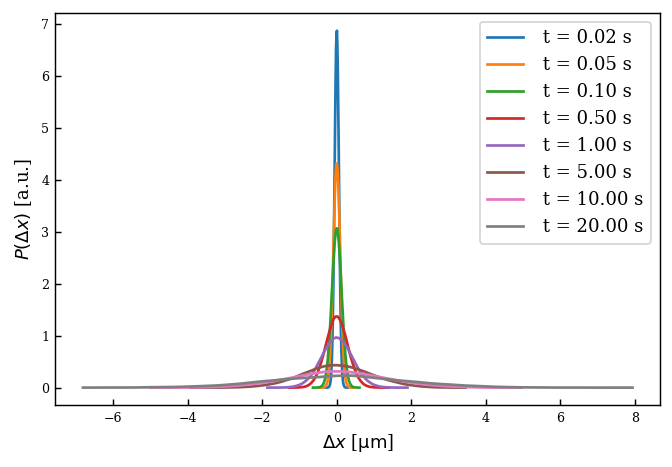

In [37]:
I = [2, 5 , 10, 50 ,100,500, 1000,2000]   

for i in I:
    
    Dezs = x[0:-i] - x[i:]
    hist, bins_center = pdf(Dezs, bins = 50)

    plt.plot(bins_center, hist, label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



If we now normalize by the standard deviation


In [38]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

Text(0.5, 0, 'normalized $\\Delta x$ [a.u.]')

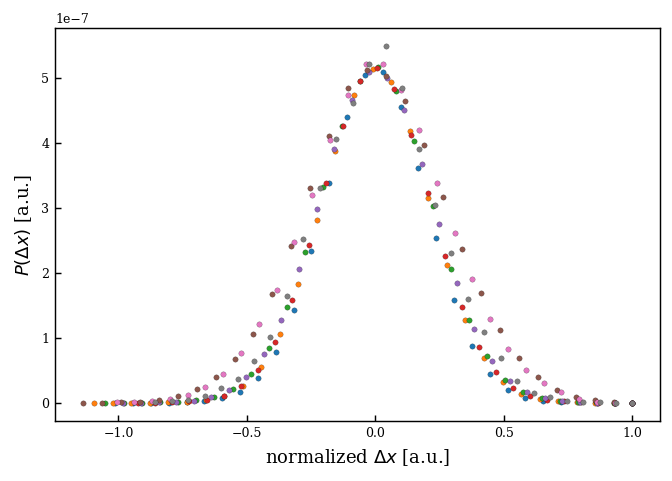

In [39]:

for n,i in enumerate(I):
    
    Dezs = (x[0:-i] - x[i:])
    Dezs = Dezs / np.sqrt(2 * Do * time[i])
    hist, bins_center = pdf(Dezs, bins = 30)

    #if i == I[0]:
    #    popt, pcov = curve_fit(gauss_function, bins_center/np.max(bins_center), hist, p0 = [1, np.mean(hist), np.std(hist)])
    #    plt.plot(bins_center/np.max(bins_center), gauss_function(bins_center, *popt), label = "fit at t = {:.2f} s".format(time[i]))
    #    plt.plot(bins_center/np.max(bins_center), hist, "x",label = " t = {:.2f} s".format(time[i]),color = "tab:blue")
    #    continue
        
    plt.plot(bins_center/np.max(bins_center), hist, ".",label = " $Delta$t = {:.2f} s".format(time[i]))
    
    
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("normalized $\Delta x$ [a.u.]")

We can observe that the kurtosis increase as we raise $\Delta t$

Text(0.5, 0, '$\\Delta t$ [s]')

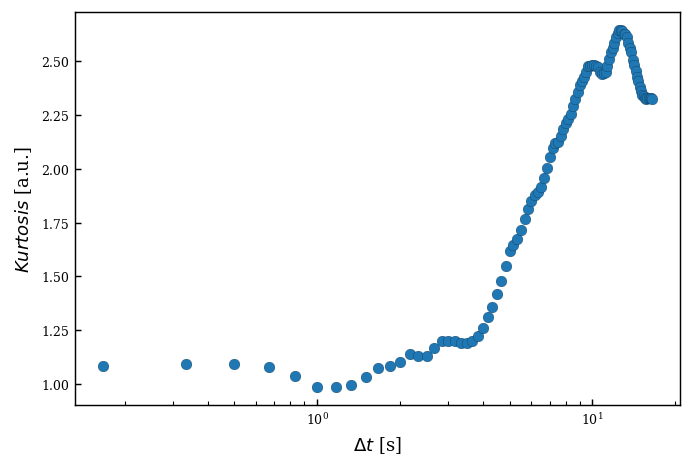

In [25]:
I = np.concatenate((
    np.arange(10,100, 10), np.arange(100,1000, 100),np.arange(100,3500, 100)))

I = np.arange(10,1000,10)
DxKurtosis = np.zeros(len(I))

def kurtosis(x, t):
    kurtosis = np.zeros(len(t))
    for n,i in enumerate(t):
        signal = (x[0:-i] - x[i:]); signal = signal - np.mean(signal)
        kurtosis[n] = np.sum(signal ** 4 )/ np.std(signal)**4  / len(signal)
    return kurtosis



DzKurtosis = kurtosis(z,I)



plt.semilogx(time[I], DzKurtosis - 3, "o")
plt.ylabel("$Kurtosis$ [a.u.]")
plt.xlabel("$\Delta t$ [s]")

Text(0.5, 0, '$\\Delta t$ [s]')

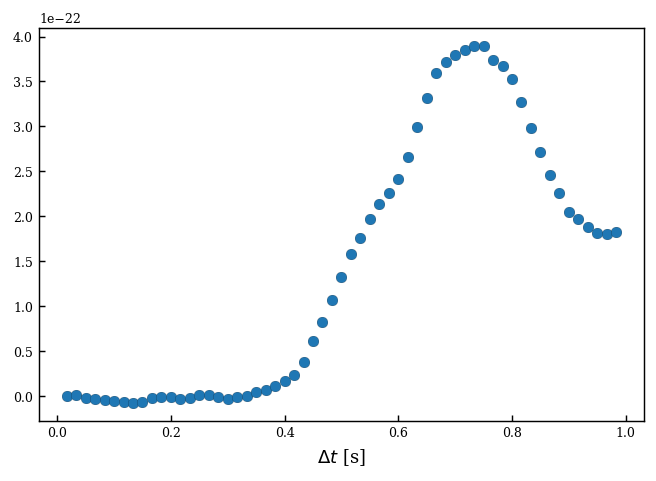

In [26]:
I = np.concatenate((
    np.arange(10,10000, 10), np.arange(100,1000, 100),np.arange(100,3500, 100)))

I = np.arange(1,60,1)
DxKurtosis = np.zeros(len(I))


def MSDn(x, t, m):
    MSD = np.zeros(len(t))
    for n,i in enumerate(t):
        MSD[n] = np.nanmean((x[i:]- x[0:-i]) ** m)
    return MSD




moment1 = MSDn(z*1e-6,I,3)



plt.plot(time[I], moment1, "o")
#plt.ylabel("$Kurtosis$ [a.u.]")
plt.xlabel("$\Delta t$ [s]")


#for m in range(1,6):
#    plt.loglog(time[I],moments(z,I,m),label = str(m))
    
#plt.legend()
    



In [42]:
6 * 0.001 / 0.2 * np.pi * r * 1e-10 * 1e15

0.01413716694115407

In [43]:
(3.5e-22)**(1/3)

7.047298732064899e-08

We can see a clear change but we would need to average on different trajectectories to have consitant results.

# Pdf of the $\Delta z$¶


Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

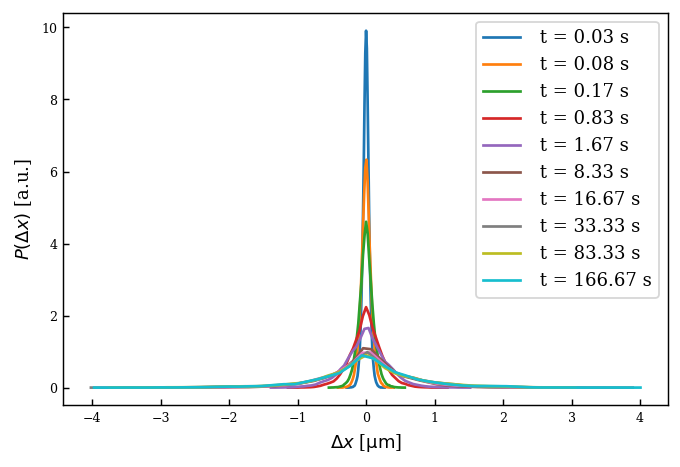

In [29]:
I = [2, 5 , 10, 50 ,100,500, 1000, 2000, 5000, 10000]   

for i in I:
    
    Dezs = z[0:-i] - z[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 50)

    plt.plot(bins_center, hist, label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")


Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

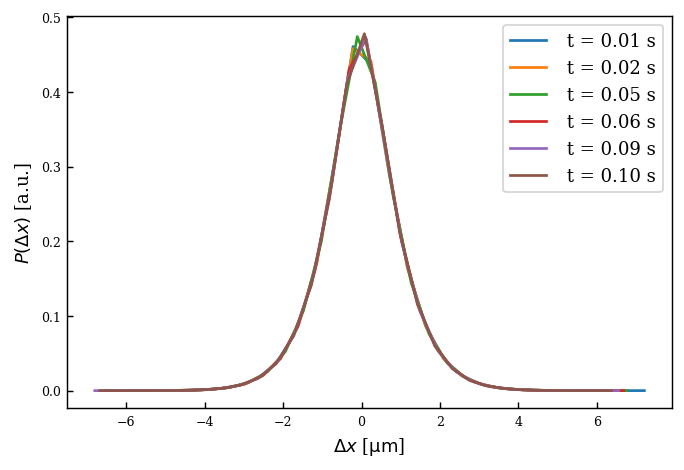

In [46]:
for i in I:
    
    Dezs = (z[0:-i] - z[i:])
    Dezs = Dezs / np.nanstd(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)

    plt.plot(bins_center, hist, label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



At long time it seems non gaussian ! Let's focus on the short time


(1e-05, 1)

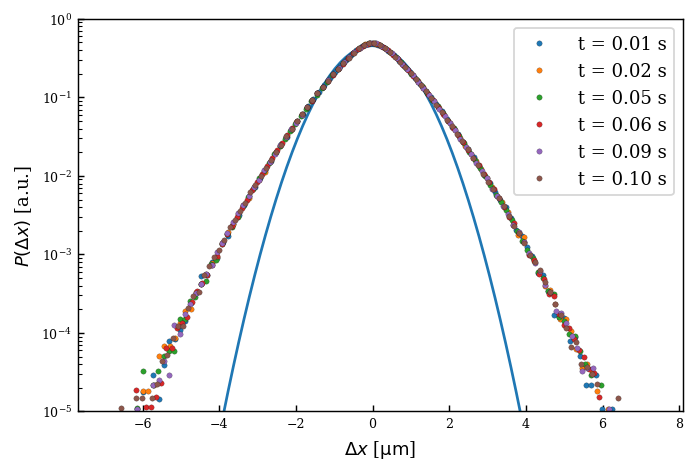

In [47]:
I = [1,2,5,6,9,10]

for i in I:
    
    Dezs = (z[0:-i] - z[i:])
    Dezs = Dezs / np.std(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 100)
    
    if i == I[0]:
        popt, pcov = curve_fit(gauss_function, bins_center, hist, p0 = [1, np.mean(hist), np.std(hist)])
        plt.plot(bins_center, gauss_function(bins_center, *popt))
        plt.plot(bins_center, hist, ".",label = " t = {:.2f} s".format(time[i]),color = "tab:blue")
        continue
    plt.semilogy(bins_center, hist, "." ,label = " t = {:.2f} s".format(time[i]))
    
plt.legend()
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")
axes = plt.gca()
axes.set_ylim([1e-5,1])

In [48]:
popt

array([ 0.45515252, -0.0130716 ,  0.83451987])



The non gausianity is due to the fact that the diffusion coefficient vary as a funtion of the height, thus it vary during the diffusion (diffusing diffusivity) process knowing that one can write :
\begin{equation} P(\Delta z , \Delta t) = \int_0 ^\infty dDP(D) \frac{1}{\sqrt{4 \pi D \Delta t}} exp\left[ \frac{-\Delta z ^2}{4D\Delta t} \right] \end{equation}

from Test of the diffusing-diffusivity mechanism using near-wall colloidal dynamics Mpumelelo M. et al.


Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

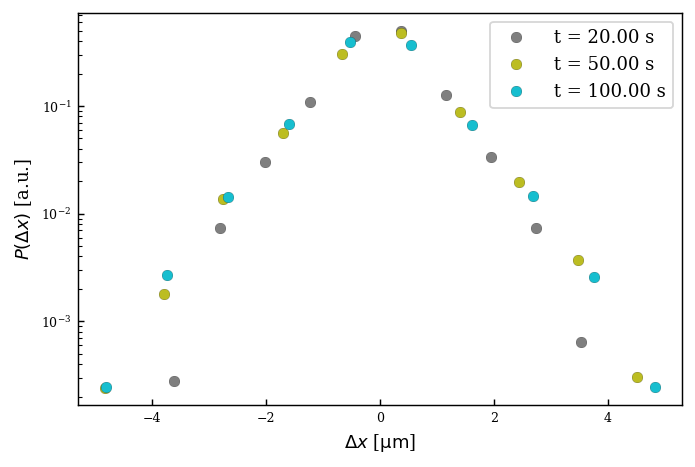

In [49]:
I = [2000, 5000, 10000]   

color_long_time = ["tab:gray","tab:olive","tab:cyan"]
for n,i in enumerate(I):
    
    Dezs = z[0:-i] - z[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)],  bins = 10)

    plt.semilogy(bins_center, hist, "o",label = " t = {:.2f} s".format(time[i]), color = color_long_time[n])
    
plt.legend()

plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



Indeed at long time it becomes exponential and it's no longer dependent on $\Delta t$

At very long time intervals $\Delta t$ each position measurment can be seen as random measurment on the le Boltzman distribution. Thus, one can write the probability distribution as : \begin{equation} P(\Delta z) = \int ^ \infty _{- \infty} dz P_B (z)P_B (z + \Delta z), \end{equation}

with :
\begin{equation} P_B(z) = Ae^{\left(Bexp\left(-\frac{z}{l_d}\right) - \frac{z}{l_b}\right)} \end{equation}

Also, $P_B(z < 0)$

giving at long time step : \begin{equation} P(\Delta z) = A'exp \left[Bexp\left[-\frac{z}{l_d}\right] (1 + exp[- \frac{\Delta z}{ l_d}]) - \frac{ 2z + \Delta z}{l_b} \right] \end{equation}



## Analysis of pdf of the $\Delta z$ at large time step

To have a better data set we are going to measure the pdf of the $\Delta z$ for a lot of different time step and we arge going to average them. But first of all we need to get rid of the drifts at long time. The best way to do that is to a moving average, taking a box long enough to assume that the mean value should be equal to the equilibrium mean value. We can estimate the time over wich we have to average with the MSD of z and the time it takes to reach the plateau. Here we will look at times > at 30s


## Dedrifting the z trajectory

In [71]:
def movmean(datas, k):
    result = np.empty_like(datas)
    start_pt = 0
    end_pt = int(np.ceil(k / 2))

    for i in range(len(datas)):
        if i < int(np.ceil(k / 2)):
            start_pt = 0
        if i > len(datas) - int(np.ceil(k / 2)):
            end_pt = len(datas)
        result[i] = np.mean(datas[start_pt:end_pt])
        start_pt += 1
        end_pt += 1

    return result

def movmin(z, window):
    result = np.empty_like(z)
    start_pt = 0
    end_pt = int(np.ceil(window / 2))

    for i in range(len(z)):
        if i < int(np.ceil(window / 2)):
            start_pt = 0
        if i > len(z) - int(np.ceil(window / 2)):
            end_pt = len(z)
        result[i] = np.min(z[start_pt:end_pt])
        start_pt += 1
        end_pt += 1

    return result

In [65]:
#z_dedrift = z - movmean(z,20000)

# With the quality of the data we are just going to -min

z_dedrift = z#- np.min(z)

In [55]:
plt.plot(time,movmean(z,10000))

KeyboardInterrupt: 

In [37]:
60000/60/60

16.666666666666668

Text(0, 0.5, 'z [$\\mathrm{\\mu m}$]')

/home/expensia/miniconda3/envs/analysis/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


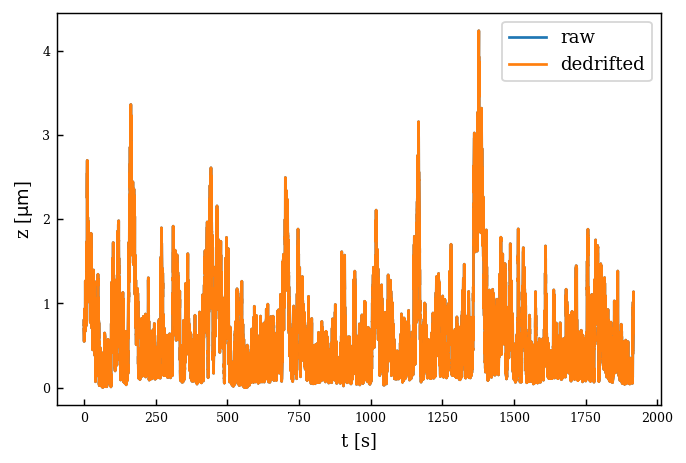

In [38]:


# Fig for comparing the two

plt.plot(time,z-np.min(z), label = "raw")
plt.plot(time,z_dedrift, label = "dedrifted")
plt.legend()

plt.xlabel("t [s]")
plt.ylabel("z [$\mathrm{\mu m}$]")

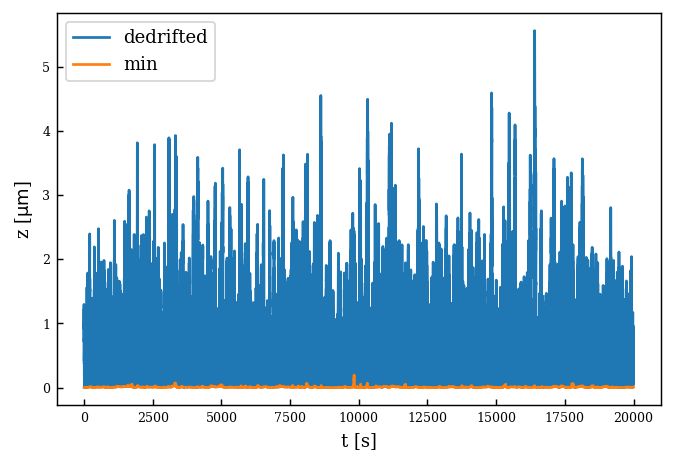

In [72]:
#plt.plot(time,z-np.min(z), label = "raw")
plt.plot(time,z_dedrift, label = "dedrifted")
plt.plot(time,movmin(z_dedrift,10000), label = "min")
plt.legend()

plt.xlabel("t [s]")
plt.ylabel("z [$\mathrm{\mu m}$]")


z_dedrift = z_dedrift #- movmin(z_dedrift,10000)

## Measuring pdf at large $\Delta t$ and analysing it

In [67]:


t_start = 25
t_end = 30
I = np.arange(t_start*fps,t_end*fps) 
bins = 50

hists = np.zeros((bins,len(I)))
bins_centers = np.zeros((bins,len(I)))

for n,i in enumerate(I):
    
    Dezs = z_dedrift[0:-i] - z_dedrift[i:]
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)],  bins = bins)
    
    hists[:,n] = hist
    bins_centers[:,n] = bins_center

    
pdf_long_t = np.mean(hists, axis = 1)
bins_centers_long_t = np.mean(bins_centers, axis = 1)
err_long_t = np.std(hists, axis = 1)
err_bins_centers = np.std(bins_centers, axis = 1)

Text(0.5, 0, '$\\Delta x$ [$\\mathrm{\\mu m}$]')

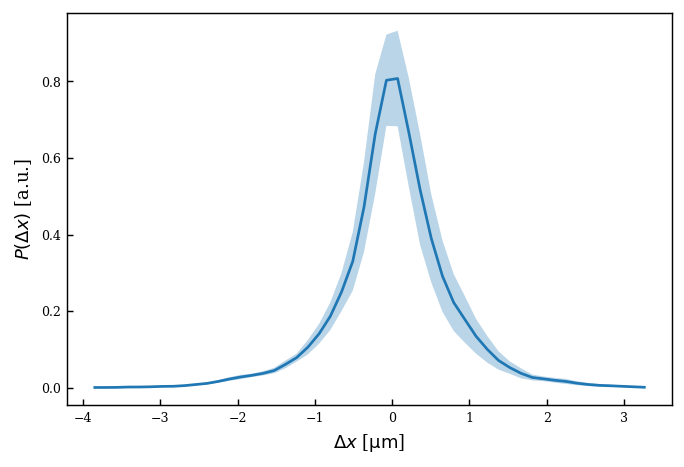

In [42]:
plt.plot(bins_centers_long_t,pdf_long_t)
plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)
plt.ylabel("$P(\Delta x)$ [a.u.]")
plt.xlabel("$\Delta x$ [$\mathrm{\mu m}$]")



We are now going to code the function
\begin{equation} P(\Delta z) = \int ^ \infty _{- \infty}A'exp \left[Bexp\left[-\frac{z}{l_d}\right] (1 + exp[- \frac{\Delta z}{ l_d}]) - \frac{ 2z + \Delta z}{l_b} \right] \end{equation}

Noting that coding the form :
\begin{equation} P(\Delta z) = \int ^ \infty _{- \infty} dz P_B (z)P_B (z + \Delta z), \end{equation}

Will be easier and $P_B$ will be reused later on. Also since $P_B(z < 0) = 0$ :
\begin{equation} P(\Delta z) = \int ^ \infty _{0} dz P_B (z)P_B (z + \Delta z), \end{equation}

with :
\begin{equation} P_B(z) = Ae^{\left(Bexp\left(-\frac{z}{l_d}\right) - \frac{z}{l_b}\right)} \end{equation}


In [75]:
def P_b(z, A, B, ld, lb):
    P_b = A * np.exp(-B * np.exp(-z / (ld)) - z / lb)
    P_b[z < 0] = 0
    return P_b

def dPdeltaz_long(z, DZ, A, B, ld, lb):
    return P_b(z, A, B, ld, lb) * P_b(z + DZ, A, B, ld, lb)

def P_computation(DZ, A, B, ld, lb):
    z = np.linspace(0, 20e-6, 1000)    
    dP = dPdeltaz_long(z, DZ, A, B, ld, lb)
    P = trapz(dP,z)
    return P

def Pdeltaz_long(DZ, B, ld, lb):
    if type(DZ) == float:
        return P_computation(i, 1, B, ld, lb)
    
    pdf = np.array([P_computation(i, 1, B, ld*1e-9, lb*1e-9) for i in DZ])
    
    # normalisation of the PDF to not use A
    
    A = trapz(pdf,DZ*1e6)
    
    return np.array([P_computation(i, 1, B, ld*1e-9, lb*1e-9) for i in DZ]) / A



In [76]:
A = 0.14e8
B = 4
ld = 70
lb = 500
p1 = [B, ld, lb]

# Normalisation fo the pdf

pdf_long_t = pdf_long_t / trapz(pdf_long_t,bins_centers_long_t)


popt, pcov = curve_fit(Pdeltaz_long, bins_centers_long_t * 1e-6,pdf_long_t,p0 = p1)
dataset["pdf_longtime"] = pdf_long_t
dataset["x_pdf_longtime"] = bins_centers_long_t * 1e-6


C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/3470205213.py:2: RuntimeWarning: overflow encountered in exp
  P_b = A * np.exp(-B * np.exp(-z / (ld)) - z / lb)


In [77]:
popt

array([  4.16618049,  60.16246705, 601.16165651])

Text(0.5, 0, '$\\Delta z$ [$\\mathrm{\\mu m}$]')

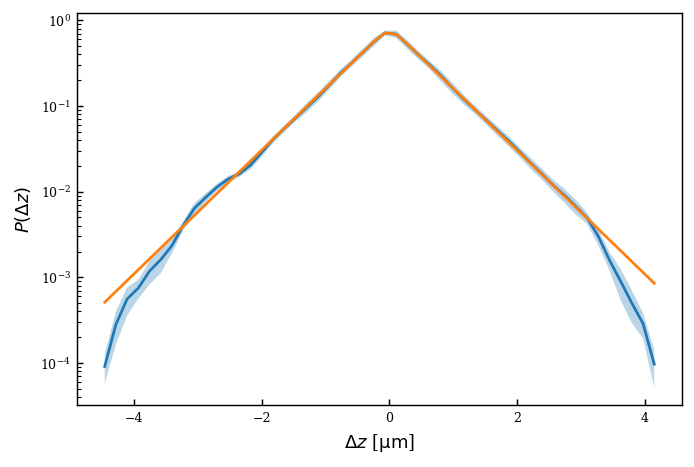

In [78]:
A = 0.14e8
B = 400
ld = 70
lb = 500
p0 = [B, ld, lb]


plt.semilogy(bins_centers_long_t,pdf_long_t, label = "experimantal pdf")
plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)

plt.plot(bins_centers_long_t,Pdeltaz_long(bins_centers_long_t*1e-6, *popt), label = "fit")
plt.ylabel("$P(\Delta z)$")
plt.xlabel("$\Delta z$ [$\mathrm{\mu m}$]")

In [79]:
print("We measure, B = {:.2f}, ld = {:.2f} nm, lb = {:.2f} nm".format(*popt))
B, ld, lb = popt


We measure, B = 4.17, ld = 60.16 nm, lb = 601.16 nm


## Analyse of the MSD z plateau

Text(0.5, 0, '$\\Delta$t (s)')

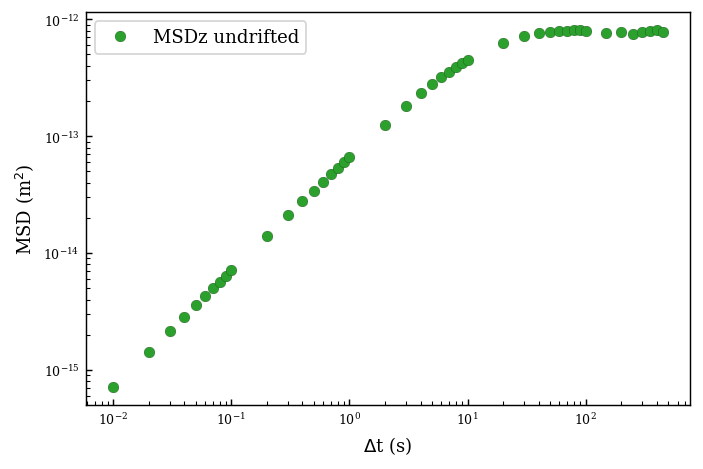

In [80]:
t = np.concatenate((np.arange(1,10, 1),np.arange(10,100, 10), np.arange(100,1000, 100),np.arange(1000,10000, 1000),np.arange(10000,50000, 5000)))

MSD_z_dedrift = MSD(z_dedrift*1e-6, t)

plt.loglog(time[t],MSD_z_dedrift,"o", label = "MSDz undrifted", color = "tab:green")
plt.legend()
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\Delta$t (s)")


In [81]:
def func_plateau(x,P,tau):
    return P * (1 - np.exp(-x/tau))

popt, pcov = curve_fit(func_plateau, time[t], MSD_z_dedrift, p0 = [1e-12, 100])

Text(0.5, 0, '$\\Delta$t (s)')

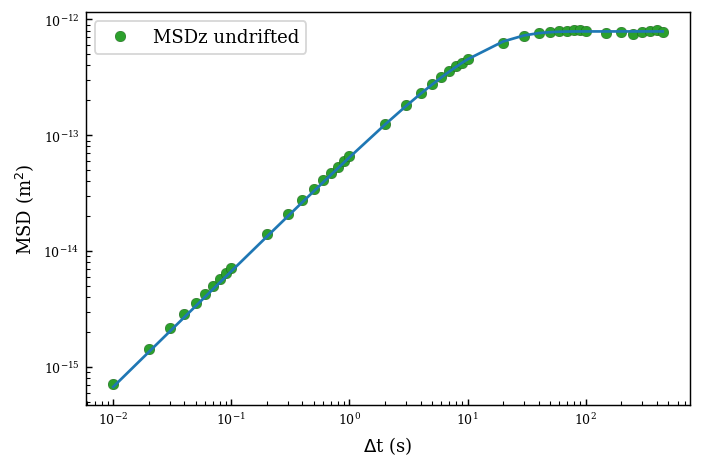

In [82]:
plt.loglog(time[t],MSD_z_dedrift,"o", label = "MSDz undrifted", color = "tab:green")
plt.plot(time[t], func_plateau(time[t], *popt))
plt.legend()
plt.ylabel("MSD (m$^2$)")
plt.xlabel("$\Delta$t (s)")


In [83]:
np.mean(MSD_z_dedrift[time[t]>1e2])

7.789134372411222e-13

In [84]:


#dataset["plateau_MSD"] = popt[0]
dataset["plateau_MSD"] =np.mean(MSD_z_dedrift[time[t]>1e2])
print("Measured plateau : {:e}".format(popt[0]))

Measured plateau : 7.872661e-13


We can compute theoretically the plateau

\begin{equation} 
Plateau = \int _{-\infty} ^{+\infty} \Delta z ^ 2 P_{\Delta z, t \rightarrow +\infty}(\Delta z,B,l_d,l_b) d\Delta z
\end{equation}

In [85]:
x_Th_Plateau = bins_centers_long_t*1e-6

def Theoritical_Plateau(B,ld,lb):
    x = dataset["x_pdf_longtime"]
    P = Pdeltaz_long(x, B, ld, lb) / trapz(Pdeltaz_long(x, B, ld, lb),x)

    res = trapz((x ** 2) * P,x)
    return res



In [86]:
def minimize_plateau(x):
    B = x[0]
    ld = x[1]
    lb = x[2]
    return (np.log(Theoritical_Plateau(B,ld,lb)) - np.log(dataset["plateau_MSD"])) ** 2 / np.log(Theoritical_Plateau(B,ld,lb))**2

In [87]:
res_plateau = minimize(minimize_plateau,x0=[B,ld,lb])

In [88]:
print("We measure, B = {:.2f}, ld = {:.2f} nm, lb = {:.2f} nm".format(*res_plateau.x))


We measure, B = 4.17, ld = 60.16 nm, lb = 601.16 nm


# Deteramination of the Vestergaard error

In [89]:
Dz_g_autocor = (z[1:] - z[:-1]) * 1e-6 ; Dz_g_autocor = Dz_g_autocor - np.mean(Dz_g_autocor)
err_z = np.sqrt(np.mean(Dz_g_autocor[1:] * Dz_g_autocor[:-1]))
err_z

C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/2090188982.py:2: RuntimeWarning: invalid value encountered in sqrt
  err_z = np.sqrt(np.mean(Dz_g_autocor[1:] * Dz_g_autocor[:-1]))


nan

In [90]:
Dx_g_autocor = (x[1:] - x[:-1]) * 1e-6; Dx_g_autocor = Dx_g_autocor - np.mean(Dx_g_autocor)
err_x = np.sqrt(np.mean(Dx_g_autocor[1:] * Dx_g_autocor[:-1]))
err_x

C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/2736903702.py:2: RuntimeWarning: invalid value encountered in sqrt
  err_x = np.sqrt(np.mean(Dx_g_autocor[1:] * Dx_g_autocor[:-1]))


nan

In [91]:
Dy_g_autocor = (y[1:] - y[:-1]) * 1e-6; Dy_g_autocor = Dy_g_autocor - np.mean(Dy_g_autocor)
err_y = np.sqrt(np.mean(Dy_g_autocor[1:] * Dy_g_autocor[:-1]))
err_y

1.00476857363425e-09

## Mesure R (tps opturation = 3ms)

In [92]:
1/60

0.016666666666666666

In [93]:
def xi(t,topt):
    
    xi = np.zeros(len(t))
    xi[t<topt] = 1/topt
    return xi

def S(t,topt):
    tt = np.linspace(0,t,10000)
    
    return np.trapz(xi(tt,topt),tt)

def R(fps,topt):
    tt = np.linspace(0,1/fps,10000)
    
    S_t = np.array([S(i,topt) for i in tt])
    to_int = S_t * (1 - S_t)
    
    return fps * np.trapz(to_int,tt)
    

In [94]:
def err_vestergaard(v,fps,topt):
    autoco_1frame = np.mean(v[1:] * v[:-1])
    std_opt = 2 * mean_Dz * Do * r * 1/fps
    sigma2 = autoco_1frame - std_opt
    
    return np.sqrt(sigma2)

    

In [95]:
topt = 3e-3
err_vestergaard(Dy_g_autocor,fps,topt)

1.0042346029215223e-09

In [96]:
err_vestergaard(Dx_g_autocor,fps,topt)

C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/688841781.py:6: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


nan

In [97]:
sigmaz = err_vestergaard(Dz_g_autocor,fps,topt)

C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/688841781.py:6: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


In [98]:
std_opt = 2 * mean_Dz * Do * r * 1/fps

In [99]:
autoco_1frame = np.mean(Dz_g_autocor[1:] * Dz_g_autocor[:-1])
sigma2 = autoco_1frame - std_opt
np.sqrt(sigma2)

C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/868882373.py:3: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(sigma2)


nan


## Analyse PDF de z

In [100]:
def logarithmic_hist(data,begin,stop,num = 50,base = 2):
    
    if begin == 0:
        beg = stop/num
        bins = np.logspace(np.log(beg)/np.log(base), np.log(stop)/np.log(base), num-1, base=base)
        widths = (bins[1:] - bins[:-1])
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0],bins))
        widths = (bins[1:] - bins[:-1])
    
    else:
        bins = np.logspace(np.log(begin)/np.log(base), np.log(stop)/np.log(base), num, base=base)
        widths = (bins[1:] - bins[:-1])
    
    hist,bins = np.histogram(data, bins=bins,density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1])/2
    
    return bins_center,widths, hist

Text(0, 0.5, 'P(z) [a.u.]')

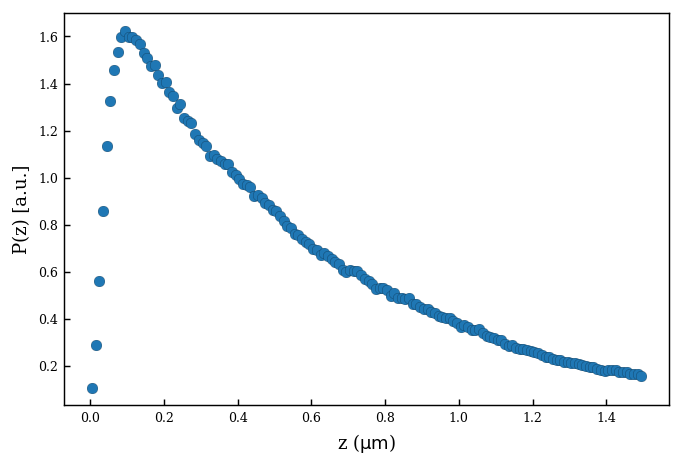

In [101]:
pdf_z, bins_center_pdf_z = pdf(z_dedrift[z_dedrift < 1.5],  bins = 150)
plt.plot(bins_center_pdf_z,pdf_z, "o")
plt.xlabel("z ($\mathrm{\mu m}$)")
plt.ylabel("P(z) [a.u.]")





The idea now is to find where the substrate is, to do this we will use a first method which consist to adjust the PDF with an offset to make it fit with the measured mean Diffusion coefficient. With :
\begin{equation} 
< D_i > = \int _{-\infty} ^{\infty} dz D_i(z)P(z) 
\end{equation}

For z we are going to use the Padé approx :
\begin{equation} D_z (z) \approx D_0 \left( \frac{6z^2 + 2rz}{6z^2 + 9rz + 2r^2} \right) \end{equation}

For x we are going to use the Faxen formula :
\begin{equation} D_x (z) \approx D_0 \left[ 1 - \frac{9}{16} \left(\frac{r}{z}\right) + \frac{1}{8} \left(\frac{r}{z}\right)^3 - \frac{45}{236} \left(\frac{r}{z}\right)^4 - \frac{1}{16} \left(\frac{r}{z}\right)^5 \right] \end{equation}

To do this we will fit the PDF with an offset, adjust it with the mean value of z. Let's first do it over z


In [102]:


def P_b_off(z,z_off,  B, ld, lb):
    z_off = z_off * 1e-6 
    lb = lb * 1e-9
    ld = ld * 1e-9
    z = z - z_off
    P_b = np.exp(-B * np.exp(-z / (ld)) - z / lb)
    P_b[z < 0] = 0
    
    # Normalization of P_b
    
    A = trapz(P_b,z * 1e6)
    P_b = P_b / A
    
    
    return P_b



In [103]:
#Normalization of the PDF

pdf_z = pdf_z / trapz(pdf_z,bins_center_pdf_z)


p2 = [0,B, ld, lb]

popt, pcov = curve_fit(P_b_off, bins_center_pdf_z * 1e-6,pdf_z, p0 = p2) 


C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/2468732054.py:12: RuntimeWarning: invalid value encountered in true_divide
  P_b = P_b / A


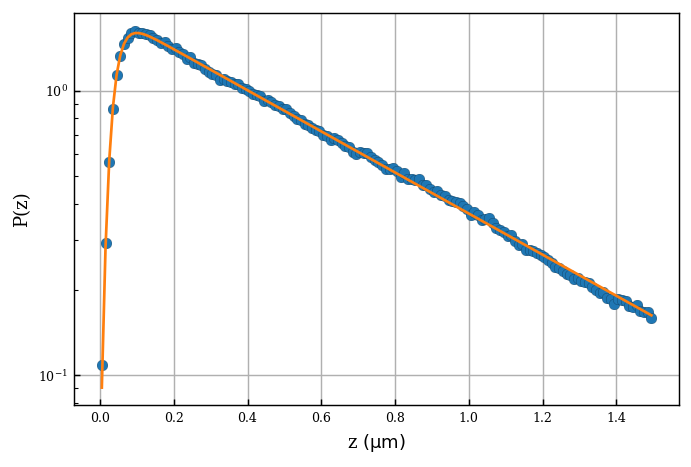

In [104]:


plt.semilogy(bins_center_pdf_z,pdf_z, "o")
plt.plot(bins_center_pdf_z,P_b_off(bins_center_pdf_z*1e-6,*popt))

plt.xlabel("z $\mathrm{(\mu m)}$")
plt.ylabel("P(z)")
plt.grid()


In [105]:
pdf_z[pdf_z>0]

array([0.10903619, 0.29181425, 0.56387918, 0.8607829 , 1.13616704,
       1.32757507, 1.45901595, 1.53646429, 1.59952936, 1.62647031,
       1.59975064, 1.5999166 , 1.58885255, 1.56871598, 1.5302131 ,
       1.51151486, 1.47771419, 1.48103341, 1.4372751 , 1.40568724,
       1.41005754, 1.36441835, 1.34743503, 1.29598721, 1.31391097,
       1.25626728, 1.24066697, 1.23380726, 1.18888723, 1.16343992,
       1.14844814, 1.13788197, 1.09401302, 1.09766416, 1.07913188,
       1.0739871 , 1.05999108, 1.05965916, 1.02668829, 1.0141306 ,
       0.99493448, 0.97275106, 0.96937653, 0.96008273, 0.92390329,
       0.92600546, 0.91499673, 0.89198352, 0.88545573, 0.86437872,
       0.86150206, 0.83815692, 0.81763312, 0.79727527, 0.78764955,
       0.76275544, 0.75965751, 0.74162311, 0.72834625, 0.72038014,
       0.69775416, 0.69471155, 0.67241749, 0.68027296, 0.6697068 ,
       0.65482566, 0.64160412, 0.6330848 , 0.61029286, 0.59989266,
       0.60879922, 0.60498212, 0.60376508, 0.58573068, 0.56952

In [106]:
trapz(pdf_z,bins_center_pdf_z)

1.0



By keeping the all the result of the fit except the fit, we will check wich offset gives us the right an put the offset to 0


In [107]:


#z_dedrift = z_dedrift - popt[0]
#pdf_z, bins_center_pdf_z = pdf(z_dedrift[~np.isnan(z_dedrift)],  bins = 100)

#p2 = [np.min(bins_center_pdf_z),np.max(pdf_z),B, ld, lb]
#popt, pcov = curve_fit(P_b_off, bins_center_pdf_z * 1e-6,pdf_z, p0 = p2) 

#plt.plot(bins_center_pdf_z,pdf_z, "o")
#plt.plot(bins_center_pdf_z,P_b_off(bins_center_pdf_z*1e-6,*popt))

#plt.xlabel("Height ($\mu$m)")
#plt.ylabel("P(Height)")



In [108]:


mean_Dx = (popt_1[0]+popt_2[0])/2
mean_Dz = popt_3[0]
print("We measure a m mean diffusion coefficient of {:.3f}D0 for the perpendicular motion and of {:.3f}D0 for the parallel motion".format((popt_1[0]+popt_2[0])/2, popt_3[0]))


dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz

We measure a m mean diffusion coefficient of 0.606D0 for the perpendicular motion and of 0.253D0 for the parallel motion


In [109]:


Do = 4e-21/(6*np.pi*0.001*r)

def Dz_z(z):
    result = ((6*z*z + 2*r*z) / (6*z*z + 9*r*z + 2*r*r))
    return result
    
def Dx_z(z):
    result = (1 - 9/16*(r/(z+r)) + 1/8*(r/(z+r))**3 - 45/256*(r/(z+r))**4 - 1/16*(r/(z+r))**5)
    return result



In [110]:
mean_Dx/trapz(Dx_z(bins_center_pdf_z*1e-6) * P_b_off(bins_center_pdf_z*1e-6,-0.3,*popt[1:]),bins_center_pdf_z)

1.1635804651252226

In [111]:


def minimizer(z_off):
    Dx_pdf = trapz(Dx_z(bins_center_pdf_z*1e-6) * P_b_off(bins_center_pdf_z*1e-6,z_off,*popt[1:]),bins_center_pdf_z)
    Dz_pdf = trapz(Dz_z(bins_center_pdf_z*1e-6) * P_b_off(bins_center_pdf_z*1e-6,z_off,*popt[1:]),bins_center_pdf_z)
    
    return np.abs((1 - mean_Dx/Dx_pdf) + (1 - mean_Dx/Dx_pdf))
    
    
res = minimize(minimizer, 0, method='nelder-mead')



In [112]:
offset = res

In [113]:


offset = np.mean(res["final_simplex"][0])
print("We measure an offset of {:.3f} um".format(offset))



We measure an offset of 0.185 um


In [114]:
len(bins_center_pdf_z)

150

Text(0, 0.5, 'P(z)')

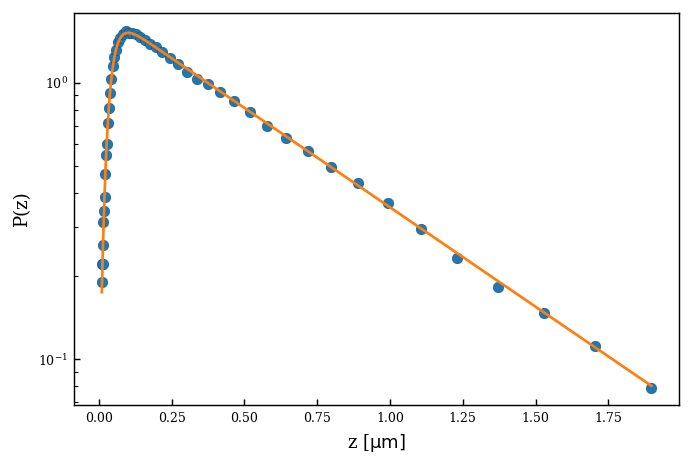

In [115]:
#z_dedrift = z_dedrift - offset
#z_dedrift[z_dedrift < 0 ] = np.nan

def logarithmic_hist(data,begin,stop,num = 50,base = 2):
    
    if begin == 0:
        beg = stop/num
        bins = np.logspace(np.log(beg)/np.log(base), np.log(stop)/np.log(base), num-1, base=base)
        widths = (bins[1:] - bins[:-1])
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0],bins))
        widths = (bins[1:] - bins[:-1])
    
    else:
        bins = np.logspace(np.log(begin)/np.log(base), np.log(stop)/np.log(base), num, base=base)
        widths = (bins[1:] - bins[:-1])
    
    hist,a= np.histogram(data, bins=bins,density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1])/2
    
    return bins_center,widths, hist



#bins_center_pdf_z,widths,hist = logarithmic_hist(z_0offset, 0.001, 3, num = 31,base=2)


#pdf_z, bins_center_pdf_z = pdf(z_dedrift[z_dedrift < 3],  bins = 100)
bins_center_pdf_z,widths, pdf_z = logarithmic_hist(z_dedrift,0.01,2,num = 50,base = 12)

p2 = [0, B, ld, lb]
popt_pdf, pcov_pdf = curve_fit(P_b_off, bins_center_pdf_z * 1e-6,pdf_z, p0 = p2) 
dataset["pdf_z"] = pdf_z
dataset["x_pdf_z"] = bins_center_pdf_z * 1e-6

plt.semilogy(bins_center_pdf_z,pdf_z, "o")
plt.plot(bins_center_pdf_z,P_b_off(bins_center_pdf_z*1e-6,*popt_pdf))

plt.xlabel("z [$\mathrm{\mu m}]$")
plt.ylabel("P(z)")

In [116]:
pdf_z

array([0.18953559, 0.22159666, 0.22032683, 0.25912682, 0.31267333,
       0.34450431, 0.38667579, 0.46868449, 0.54759844, 0.60177208,
       0.71784729, 0.80911736, 0.91764546, 1.03233847, 1.14569706,
       1.23721341, 1.31331298, 1.4041906 , 1.45019428, 1.50413314,
       1.54297455, 1.51489308, 1.51731029, 1.50408318, 1.45940687,
       1.4259512 , 1.38487916, 1.34197797, 1.29007896, 1.22522671,
       1.16468237, 1.09636726, 1.03381643, 0.99118442, 0.92736784,
       0.86010044, 0.78664259, 0.69997378, 0.62948613, 0.56503893,
       0.49475393, 0.43507698, 0.36611313, 0.29649961, 0.23300701,
       0.18294375, 0.14708699, 0.11187847, 0.07897989])

In [117]:
offset_pdf, B_pdf, ld_offset, lb_offset = popt_pdf

In [118]:
lb_offset

603.7821080535681

Text(0, 0.5, 'Height [$\\mathrm{ \\mu m }$]')

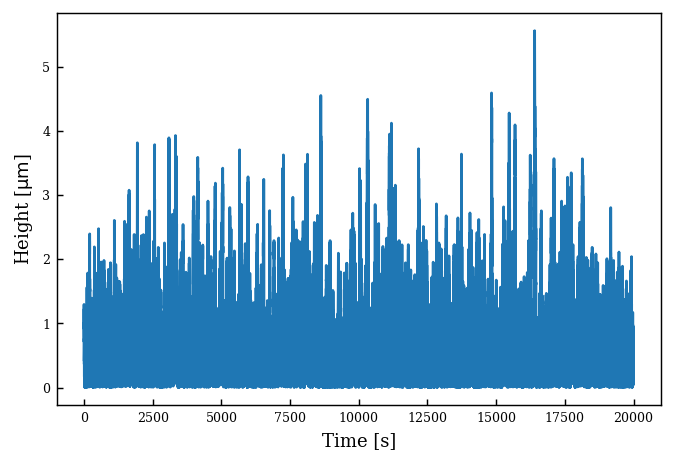

In [119]:
plt.plot(time,z_dedrift)
plt.xlabel("Time [s]")
plt.ylabel("Height [$\mathrm{ \mu m }$]")



Now that we have the deduce the offset of the trajectory we can measure the the diffusion coefficient.



# Measure of the diffusion coefficient

We are going to measure the diffusion coefficient by averaging small part of the trajectory as a function of the height.

## Measure of the perpendicular diffusion coefficient


In [120]:
def dzz():
    Y = bins_center_pdf_z * 1e-6
    z = z_dedrift * 1e-6
    Dz = np.zeros_like(Y[:-1])
    err = np.zeros_like(Y[:-1])
    
    
    for i in range(len(Y) - 1):

        with np.errstate(invalid="ignore"):
            args = np.squeeze(np.argwhere(((z > Y[i]) & (z < Y[i + 1]))))
            args = args[args < (len(z) - 10)]

            if len(args) < 10:
                Dz[i] = np.nan
                err[i] = np.nan
                continue

            trajs = np.zeros((len(args), 5))
            global_sigma = np.zeros_like(trajs[0, :])

            for n, j in enumerate(args):
                trajs[n, :] = z[j + 3 : j + 8]

            for j in range(len(trajs[0, :])):
                mu, sigma = norm.fit(trajs[:, j][~np.isnan(trajs[:, j])])
                global_sigma[j] = sigma ** 2 / 2

            func = lambda x, a, b: a * x + b
            time = np.array(range(3, 8)) / 60
            popt, pcov = curve_fit(func, time, global_sigma)
            a, b = popt
            perr = np.sqrt(np.diag(pcov))
            Dz[i] = a
            err[i] = perr[0]

    return Dz, err

In [121]:
Dz, err = dzz()

Text(0, 0.5, '$D_\\mathrm{z} (z) / D_\\mathrm{0}$')

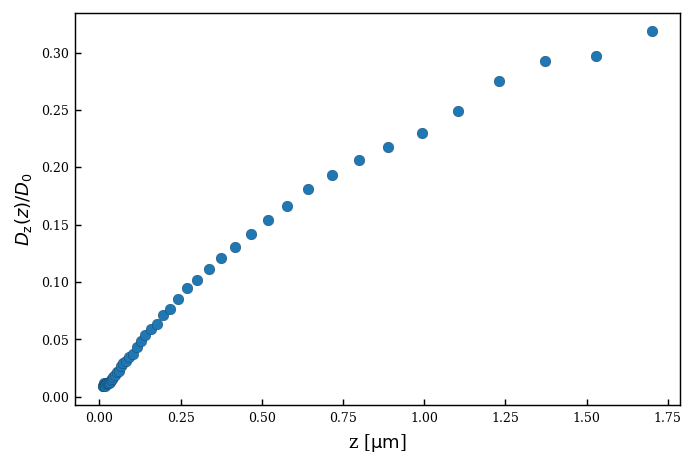

In [122]:


#plt.plot(bins_center_pdf_z[:-1], Dz/Do, "o")
#plt.fill_between(bins_center_pdf_z[:-1], Dz-err, Dz+err, alpha = 0.3)
plt.errorbar(bins_center_pdf_z[:-1], Dz/Do,yerr=err/Do, linewidth = 3, marker = "o", linestyle = "")
plt.xlabel("z [$\mathrm{\mu m}$]")
plt.ylabel("$D_\mathrm{z} (z) / D_\mathrm{0}$")





We are going to analyse the data < 1.5 um since theire is more stats it's more accurate.


In [123]:
def Dz_z(z,off):
    off = off * 1e-6
    z = z - off
    result = ((6*z*z + 2*r*z) / (6*z*z + 9*r*z + 2*r*r))
    return result

y_fit = Dz/Do
x_fit = bins_center_pdf_z[:-1]
x_fit = x_fit[~np.isnan(y_fit)]
y_fit = y_fit[~np.isnan(y_fit)]
popt, pcov = curve_fit(Dz_z, x_fit*1e-6, y_fit, p0 = [0]) 
dataset["Dz"] = y_fit
dataset["x_fit_Dz"] = x_fit*1e-6

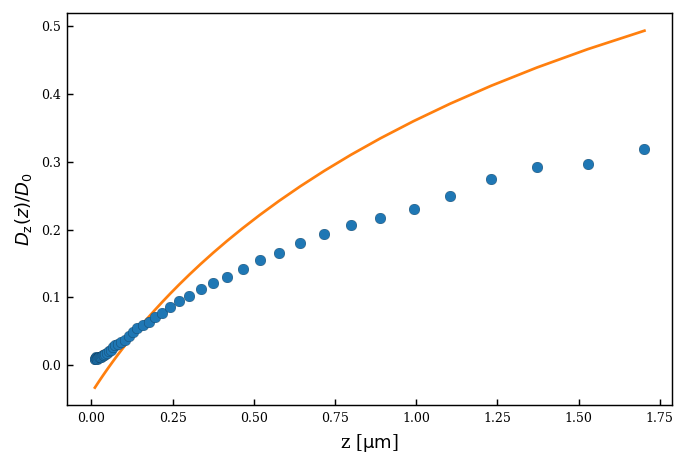

In [124]:
#plt.plot(bins_center_pdf_z[:-1], Dz, "o")
#plt.fill_between(bins_center_pdf_z[:-1], Dz-err, Dz+err, alpha = 0.3)
plt.errorbar(bins_center_pdf_z[:-1], Dz/Do, yerr=err/Do, linewidth = 3, marker = "o", linestyle = "")
plt.plot(x_fit, Dz_z(x_fit*1e-6,popt))
plt.xlabel("z [$\mathrm{\mu m}$]")
plt.ylabel("$D_\mathrm{z} (z) / D_\mathrm{0}$")
plt.savefig("Dzz.png")

In [125]:
popt

array([0.0577106])

## Measure of the perpendicular diffusion coefficient
We are now going to do the same computation but along x and y

In [126]:
def hist(x, bins, cutoff=None):
    bins = bins
    if cutoff == None:
        X, Y = np.histogram(x, bins=bins, density=True)
        Y = (Y[:-1] + Y[1:]) / 2
        return X, Y
    X, Y = np.histogram(x, bins=bins, range=(0, cutoff), density=True)
    Y = (Y[:-1] + Y[1:]) / 2
    return X, Y


def gaus(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))


def Dxx():
    z = z_dedrift * 1e-6
    Y = bins_center_pdf_z * 1e-6
    x_x = x * 1e-6
    y_y = y * 1e-6

    

    Dx = np.zeros((4, len(Y[:-1])))
    Dy = np.zeros((4, len(Y[:-1])))

    errx = np.zeros((4, len(Y[:-1])))
    erry = np.zeros((4, len(Y[:-1])))

    for k, t in enumerate(range(3, 4)):

        diff_x = x_x[t:] - x_x[:-t]
        diff_y = y_y[t:] - y_y[:-t]

        for i in range(len(Y[:-1])):

            with np.errstate(invalid="ignore"):
                args = np.squeeze(np.argwhere(((z > Y[i]) & (z < Y[i + 1]))))
                args = args[args < (len(z) - t)]

            if len(args) < 100:
                Dy[k, i] = np.std(DX*1e6)** 2 / (2 * (t / 60))
                Dx[k, i] = np.std(DY*1e6)** 2 / (2 * (t / 60))
                errx[k, i] = 0
                erry[k, i] = 0

                continue

            DX = diff_x[args]
            DY = diff_y[args]

            X_DX, Y_DX = hist(DX, 15)
            X_DY, Y_DY = hist(DY, 15)
            mean_X = np.mean(DX*1e6)
            sigma_X = np.std(DX*1e6)
            mean_Y = np.mean(DY*1e6)
            sigma_Y = np.std(DY*1e6)

            popt_X, pcov_X = curve_fit(
                gaus, Y_DX * 1e6, X_DX / np.sum(X_DX), p0=[0.1, mean_X, sigma_X]
            )

            popt_Y, pcov_Y = curve_fit(
                gaus, Y_DY * 1e6, X_DY / np.sum(X_DY), p0=[1, mean_Y, sigma_Y]
            )

            perr_X = np.sqrt(np.diag(pcov_X))
            perr_Y = np.sqrt(np.diag(pcov_Y))
            #print(popt_X[2]*1e-6 ** 2 / (2 * (t / 75)))
            Dx[k, i] = (popt_X[2]*1e-6) ** 2 / (2 * (t / 60))
            Dy[k, i] = (popt_Y[2]*1e-6) ** 2 / (2 * (t / 60))
            errx[k, i] = (perr_X[2]*1e-6) ** 2 / (2 * (t / 60))
            erry[k, i] = (perr_Y[2]*1e-6) ** 2 / (2 * (t / 60))

        Dx = np.nanmean(Dx, axis=0)
        Dy = np.nanmean(Dy, axis=0)
        err_dx = np.nanmean(errx, axis=0)
        err_dy = np.nanmean(erry, axis=0)
        
        return Dx, errx,Dy, erry


In [127]:
#Dx, err_dx,Dy, err_dy = Dxx()

In [128]:
#plt.plot(bins_center_pdf_z[:-1], Dx/Do)
#plt.plot(bins_center_pdf_z[:-1], Dy/Do)
#plt.xlabel("z [$\mathrm{\mu m}$]")
#plt.ylabel("$D_{\mathrm{xy}} (z)/ D_\mathrm{0}$")



This method do not work properly with the x and y axis, i'm going to use another method (probably not working because of the larger drifts on x and y ?)


In [129]:
def Dxx():
    
    # We frist get all the different variables of the problem
    z = z_dedrift * 1e-6
    Y = bins_center_pdf_z * 1e-6
    x_x = x * 1e-6
    y_y = y * 1e-6

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.  
    times = [3,4,5,6]
    
    # We initialize the variable used to store the results.
    # For the diffusion coefficient itself.
    Dx = np.zeros((len(times), len(Y[:-1])))
    Dy = np.zeros((len(times), len(Y[:-1])))

    # For the error
    errx = np.zeros((len(times), len(Y[:-1])))
    erry = np.zeros((len(times), len(Y[:-1])))
    
    
    for n, i in enumerate(times):
        
        # Conpute the Delta x = x(Dt + t) - x(t) for given Dt -- same over y
        Dxs = x_x[i:] - x_x[0:-i]
        Dys = y_y[i:] - y_y[0:-i]
        
        # Now for each z-bin we are going to measure the diffusion coefficient.
        
        for m in range(len(Y)-1):
            
            # We take the Dx corresponding the actual bin 
            dx = Dxs[(z[range(len(Dxs))] > Y[m]) & (z[range(len(Dxs))] < Y[m+1])]
            dy = Dys[(z[range(len(Dxs))] > Y[m]) & (z[range(len(Dxs))] < Y[m+1])]
            
            # We now do the probability distribution
            
            X_DX, Y_DX = hist(dx, 15)
            X_DY, Y_DY = hist(dy, 15)
            
            # We initialsize and fit the pdf with a gaussian
            mean_X = np.mean(Y_DX * 1e6)
            sigma_X = np.std(Y_DX * 1e6)
            mean_Y = np.mean(Y_DY * 1e6)
            sigma_Y = np.std(Y_DY * 1e6)
             
            #return Y_DX * 1e6, X_DX / np.sum(X_DX)
            try :  
                popt_X, pcov_X = curve_fit(
                    gaus, Y_DX * 1e6, X_DX / np.sum(X_DX), p0=[0.1, np.mean(Y_DX * 1e6), np.std(Y_DX * 1e6)]
                )
                popt_Y, pcov_Y = curve_fit(
                    gaus, Y_DY * 1e6, X_DY / np.sum(X_DY), p0=[1, np.mean(Y_DY * 1e6), np.std(Y_DY * 1e6)]
                )            

                sigma_X = popt_X[2] * 1e-6
                sigma_Y = popt_Y[2] * 1e-6

                # We compute the diffusion coefficient with the standard deviation
                Dx[n,m] = (sigma_X ** 2)/(2 * i/fps)
                Dy[n,m] = (sigma_Y ** 2)/(2 * i/fps)
            
            except RuntimeError:
                Dx[n,m] = np.nan
                Dy[n,m] = np.nan
                
    
    err_dx = np.nanstd(Dx, axis=0)
    err_dy = np.nanstd(Dy, axis=0)
    Dx = np.nanmean(Dx, axis=0)
    Dy = np.nanmean(Dy, axis=0)
          
    return Dx, err_dx, Dy, err_dy

In [130]:
#Dx, err_dx, Dy, err_dy = Dxx()
#plt.plot(bins_center_pdf_z[:-1], Dx/Do)
#plt.plot(bins_center_pdf_z[:-1], Dy/Do)
#plt.xlabel("z [$\mathrm{\mu m}$]")
#plt.ylabel("$D_{\mathrm{xy}} (z)/ D_\mathrm{0}$")

In [131]:
#plt.plot(bins_center_pdf_z[1:-1], Dx[1:]/Do)
#plt.plot(bins_center_pdf_z[1:-1], Dy[1:]/Do)
#plt.xlabel("z [$\mathrm{\mu m}$]")
#plt.ylabel("$D_{\mathrm{xy}} (z)/ D_\mathrm{0}$")

In [132]:


#D_para = (Dx + Dy)/2
#err_d_para = (err_dx + err_dy)



In [133]:


#plt.plot(bins_center_pdf_z[1:-1],D_para[1:]/Do)
#plt.fill_between(bins_center_pdf_z[1:-1], D_para[1:]/Do-err_d_para[1:]/Do, D_para[1:]/Do+err_d_para[1:]/Do, alpha = 0.3)
#plt.xlabel("z [$\mathrm{\mu m}$]")
#plt.ylabel("$D_{\mathrm{xy}} (z)/ D_\mathrm{0}$")


In [134]:
#D_para_fit = D_para[1:]
#z_D_para_fit = bins_center_pdf_z[1:-1]
#err_d_para_fit = err_d_para[1:]
#err_d_para_fit = err_d_para_fit[~np.isnan(D_para_fit)]
#D_para_fit = D_para_fit[~np.isnan(D_para_fit)]
#z_D_para_fit = z_D_para_fit[~np.isnan(D_para_fit)]



In [135]:


def Dx_z_off(z,offset):
    offset = offset * 1e-6
    z = z + offset # We force an positive offset, meaning the trajectory si to low
    result = (1 - 9/16*(r/(z+r)) + 1/8*(r/(z+r))**3 - 45/256*(r/(z+r))**4 - 1/16*(r/(z+r))**5)
    return result



In [136]:
#popt, pcov = curve_fit(Dx_z_off, z_D_para_fit*1e-6, D_para_fit, p0 = [0]) 
#dataset["Dx"] = D_para_fit
#dataset["x_fit_Dx"] = z_D_para_fit*1e-6


In [137]:


#plt.errorbar(z_D_para_fit, D_para_fit/Do, yerr = err_d_para_fit/Do, linewidth = 3, marker = "o", linestyle = "")
#plt.plot(z_D_para_fit, Dx_z_off(z_D_para_fit*1e-6,popt))
#plt.xlabel("z [$\mathrm{\mu m}$]")
#plt.ylabel("$D_{\mathrm{xy}} (z)/ D_\mathrm{0}$")
#plt.savefig("Dxy")


## Using the ronceray's method

In [145]:
import numpy as np
from StochasticForceInference.StochasticForceInference import *




def Compute_diffusion(pos,dt,z_min=None,z_max=None,N=20, ordre = 4, method = "Vestergaard"):
    """
    Function using the SFI from Ronseray et al. to return the diffusion alors the the different axis.
    Inputs:
        pos - np.array (len(pos),3) 3 dimensinal trajectory of the particle
        t - time step in microns
        z_min, z_max - z bounds to get Di from the computed basis using SFI
        N - length of the returned diffusion arrays
    """ 
    
    tlist = np.arange(len(pos)) * dt
    xlist = np.ones((len(pos),1,3))
    xlist[:,0,:] = pos
    data = StochasticTrajectoryData(xlist,tlist)

    S = StochasticForceInference(data)
    S.compute_diffusion(method = method, basis = {"type" : "polynomial", "order" : ordre })
    
    dir1 = np.zeros(3); dir1[0] = 1
    dir2 = np.zeros(3); dir2[1] = 1
    dir3 = np.zeros(3); dir3[2] = 1

    Rmin=data.X_ito.min(axis=(0,1))
    Rmax=data.X_ito.max(axis=(0,1))
    
    xbin=np.linspace(Rmin[0],Rmax[0],N)
    ybin=np.linspace(Rmin[1],Rmax[1],N)
    
    if z_min == None:
        z_min = Rmin[2]
    if z_max == None:
        z_max = Rmax[2]
        
    zbin = np.linspace(z_min, z_max, N)
        
    positions = [a * dir1 + b * dir2  + c * dir3 for a in xbin for b in ybin for c in zbin]
    
    NN = len(positions)
    gridX,gridY,gridZ = np.zeros(NN),np.zeros(NN),np.zeros(NN)
    Dx,Dy,Dz = np.zeros(NN),np.zeros(NN),np.zeros(NN)

    
    for n, pos in enumerate(positions):
        
        gridX[n] = dir1.dot(pos)
        gridY[n] = dir2.dot(pos)
        gridZ[n] = dir3.dot(pos)
        

        
        tensor = S.D_ansatz(pos.reshape((1,3)))
        Dx[n], Dy[n], Dz[n] = np.squeeze(tensor.diagonal(axis1 = 2))
        
    
    inflate = lambda a : np.reshape(a,(N,N,N))
    
    to_inflate = Dx, Dy, Dz, gridZ
    Dx, Dy, Dz, zz = map(inflate, to_inflate)
    del to_inflate
    
    to1d = lambda a : np.mean(np.mean(a, axis = 0),0)
    to_1d = Dx, Dy, Dz, zz
    
    Dxm, Dym, Dzm, z = map(to1d,to_1d)
    
    return  Dxm, Dym, Dzm, z

In [197]:
pos = np.zeros((300000,3))
pos[:,0] = x[:300000]*1e-6
pos[:,1] = y[:300000]*1e-6
pos[:,2] = z[:300000]*1e-6


Dx, Dy, Dz, z_D = Compute_diffusion(pos, dt = 1/100,z_min = 20e-9, z_max = 1.5e-6, ordre = 3, N = 50)

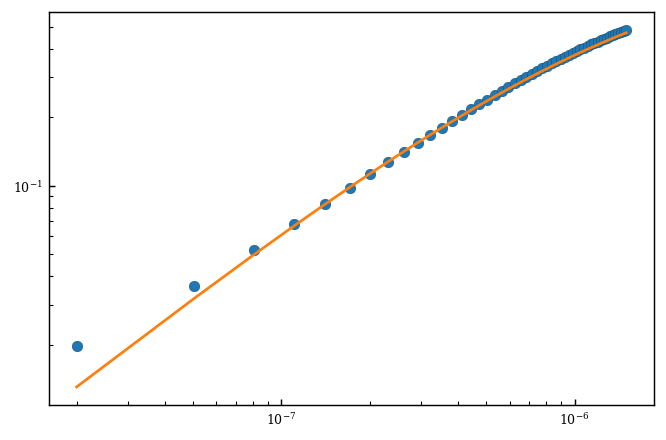

In [198]:
plt.loglog(z_D, Dz/Do, "o")
plt.plot(z_D, Dz_z(z_D,0))

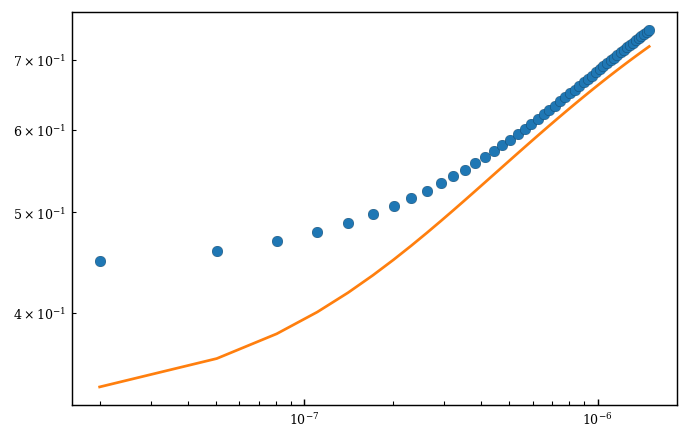

In [199]:
plt.loglog(z_D, (Dx+Dy)/(2*Do), "o")
plt.plot(z_D, Dx_z_off(z_D,0))

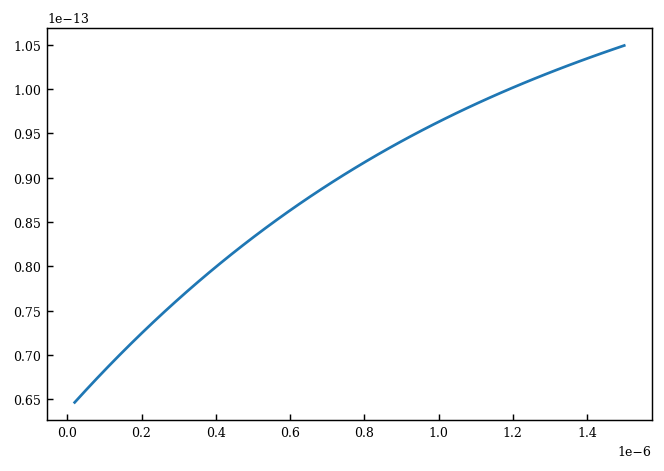

In [200]:
plt.plot(z_D, Dx)

In [201]:
#D_yacine = loadmat("../data/diffusionAnalysis.mat")["diffusion"]
dataset["z_D_yacine"] = z_D
dataset["z_D_x_yacine"] = (Dx + Dy)/2
dataset["z_D_z_yacine"] = Dz

In [202]:
def c_P_D(B,ld,lb,offset=None):
    if offset == None:
        offset = 0
        
    z = np.linspace(1e-9,15e-6,1000)
    
    P_D = Dz_z(z,offset) * Do * P_b_off(z, offset, B, ld, lb)
    
    return Dz_z(z,offset) * Do, P_D/np.trapz(P_D,z)

def _P_Dz_short_time(Dz,Dt,B,ld,lb,offset=None):
    if offset == None:
        offset = 0
    
    D_z, P_D = c_P_D(B,ld,lb,offset)
    
    P = np.trapz(P_D / np.sqrt(4 * np.pi * D_z * Dt) * np.exp(- Dz**2 / (4 * D_z*Dt)),D_z)
    
    return P

def P_Dz_short_time(Dz,Dt,B,ld,lb,offset=None):
    if offset == None:
        offset = 0
    
    P = [_P_Dz_short_time(i,Dt,B,ld,lb,offset=offset) for i in Dz]
    P = np.array(P)
    P = P / np.trapz(P,Dz)
    
    return P
    


# Fit everything in the same time !

Finaly we can fit everything in the same time to recap we have :

   - MSD x and MSD y => $< D >$
   - MSD z => $< D >$
   - mean $< D >$ with the pdf
   - Long time pdf $\Delta z$ => $l_d,l_b,B$
   - Pdf z => $offset,l_d,l_b, B$
   - D parallel, perp => offset

The minimizer $\chi ^2$ we are going to optimize can be written as :
\begin{equation} \chi^2 = \sum _{n = 1} ^{N} \chi_n^2 \end{equation}\begin{equation} \chi_n^2 = \sum^A(n) _i = 1 \frac{1}{\sigma_{ni}}(y_{ni} - y_n(x_{ni},\boldsymbol{a}))^2 \end{equation}

with $\sigma_{ni}$ the uncertainty (can be set to 1), A the number of point in the dataset for each function, $y_n$, nth equation, $\boldsymbol{a}$ the fit parameters

We have nonlinear functions so we can use the Marquardt to optimize or Nelder-Mead methods to optimize the minimizer.


In [203]:
def minimizer_diffusion_coeff(mean_D_para, mean_D_perp, z_off, B, ld, lb):
    #minimization of the mean diffusion coefficient measurement with the PDF and MSD
    a = trapz(Dx_z_off(bins_center_pdf_z*1e-6, z_off) * P_b_off(bins_center_pdf_z*1e-6,z_off, B, ld, lb),bins_center_pdf_z)
    b = trapz(Dz_z(bins_center_pdf_z*1e-6, z_off) * P_b_off(bins_center_pdf_z*1e-6,z_off, B, ld, lb),bins_center_pdf_z)
    at = mean_Dx; bt = mean_Dz
    return (a-at)**2 / at**2 + (b-bt)**2 / bt**2
    
dataset["z"] = z_dedrift
dataset["x"] = x
dataset["y"] = y


def minimizer_Dz_small_t(B,ld,lb):
    xi = 0
    
    for n,i in enumerate([1,2,3]):
        Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
        Dezs = Dezs# - np.mean(Dezs)
        
        hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)
        hist = hist/np.trapz(hist,bins_center)
        
        Dz_th = bins_center
        PPP = P_Dz_short_time(Dz_th,time[i],B,ld,lb)
        
        #xi = xi + np.nanmean((((np.abs(hist) - (PPP) ) ) ** 2) / ((np.abs(hist)**2)))
        xi = xi + np.nanmean(((hist[hist>0]-PPP[hist>0]) ** 2) / hist[hist>0]**2)
    return xi 

In [204]:
minimizer_diffusion_coeff(mean_Dx, mean_Dz, 0, B, ld, lb)

0.005412979233642115

In [205]:
minimizer_Dz_small_t(B,ld,lb)

0.2207018116067594

In [206]:
dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz


#minimizer with the log 
def minimizer(x, *args):
    #f linear function for the MSDs
    data = dataset
    #functions = [f, Pdeltaz_long, minimizer_diffusion_coeff, P_b_off, Dx_z_off]
    ld = x[0]
    lb = x[1]
    B = x[2]
    offset = x[3]
    #offset_2 = x[4]
    
  
    #chi MSDx 
    
    
    chi_mean_D_pdf = minimizer_diffusion_coeff(dataset["D_para"], dataset["D_perp"], 0, B, ld, lb)
    chi_MSD_plateau = minimize_plateau([B,ld,lb])
    
    E_longtime_pdf = (Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)) - np.log(data["pdf_longtime"])
    chi_longtime_pdf = np.mean((E_longtime_pdf[E_longtime_pdf > -np.inf] ** 2) / ((np.log(Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)))**2))
    
    E_chi_pdf_z = np.log(P_b_off(data["x_pdf_z"], 0, B, ld, lb)) - np.log(data["pdf_z"])
    chi_pdf_z = np.mean((E_chi_pdf_z[E_chi_pdf_z > -np.inf] ** 2) / (np.log(P_b_off(data["x_pdf_z"][E_chi_pdf_z > -np.inf], 0, B, ld, lb))**2))
    
    #E_D_z = np.log(Dz_z(data["x_fit_Dz"], offset)) - np.log(data["Dz"])
    #chi_D_z = np.mean(E_D_z[E_D_z > -np.inf] ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dz"], offset))**2)
    
    #E_D_x = np.log(Dx_z_off(data["x_fit_Dx"], offset)) - np.log(data["Dx"])
    #chi_D_x = np.mean(E_D_x[E_D_x > -np.inf]  ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dx"], offset))**2)
    
    E_D_z = np.log(Dz_z(data["z_D_yacine"], offset)) - np.log(data["z_D_z_yacine"] / Do)
    chi_D_z = np.mean((E_D_z[E_D_z > -np.inf] ** 2) / (np.log(Dz_z(data["z_D_yacine"][E_D_z > -np.inf], offset))**2))
    
    E_D_x = np.log(Dx_z_off(data["z_D_yacine"], offset)) - np.log(data["z_D_x_yacine"] / Do)
    chi_D_x = np.mean((E_D_x[E_D_x > -np.inf]  ** 2) / (np.log(Dx_z_off(data["z_D_yacine"], offset))**2))
    
    chi_Dz_small_t = minimizer_Dz_small_t(B,ld,lb)
    
    
    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x + chi_Dz_small_t
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  10*summ 

In [212]:
dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz


#minimizer with the log 
def minimizer(x, *args):
    #f linear function for the MSDs
    data = dataset
    #functions = [f, Pdeltaz_long, minimizer_diffusion_coeff, P_b_off, Dx_z_off]
    ld = x[0]
    lb = x[1]
    B = x[2]
    offset_dif = x[3]
    offset_boltz = 0
  
    #chi MSDx 
    
    
    chi_mean_D_pdf = minimizer_diffusion_coeff(dataset["D_para"], dataset["D_perp"],offset_boltz, B, ld, lb)
    chi_MSD_plateau = minimize_plateau([B,ld,lb])
    
    E_longtime_pdf = (Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)) - (data["pdf_longtime"])
    chi_longtime_pdf = np.mean((E_longtime_pdf[E_longtime_pdf > -np.inf] ** 2) / (((Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)))**2))
    
    E_chi_pdf_z = (P_b_off(data["x_pdf_z"], offset_boltz, B, ld, lb) - data["pdf_z"])
    chi_pdf_z = np.nanmean((E_chi_pdf_z[E_chi_pdf_z > -np.inf] ** 2) / ((P_b_off(data["x_pdf_z"], offset_boltz, B, ld, lb))**2))
    
    #E_D_z = np.log(Dz_z(data["x_fit_Dz"], offset)) - np.log(data["Dz"])
    #chi_D_z = np.mean(E_D_z[E_D_z > -np.inf] ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dz"], offset))**2)
    
    #E_D_x = np.log(Dx_z_off(data["x_fit_Dx"], offset)) - np.log(data["Dx"])
    #chi_D_x = np.mean(E_D_x[E_D_x > -np.inf]  ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dx"], offset))**2)
    
    E_D_z = (Dz_z(data["z_D_yacine"], offset_dif)) - (data["z_D_z_yacine"] / Do)
    chi_D_z = np.mean((E_D_z[E_D_z > -np.inf] ** 2) / ((Dz_z(data["z_D_yacine"], offset_dif))**2))
    
    E_D_x = (Dx_z_off(data["z_D_yacine"], offset_dif)) - (data["z_D_x_yacine"] / Do)
    chi_D_x = np.mean((E_D_x[E_D_x > -np.inf]  ** 2) / ((Dx_z_off(data["z_D_yacine"], offset_dif))**2))
    
    chi_Dz_small_t = minimizer_Dz_small_t(B,ld,lb)
    
    #return P_b_off(data["x_pdf_z"], offset, B, ld, lb)
    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x + chi_Dz_small_t
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x + chi_Dz_small_t

    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  summ 

In [213]:
B = B_pdf
ld = ld_offset
lb = lb_offset
x0 = [21,570,4.8,0]
x0

[21, 570, 4.8, 0]

In [214]:
minimizer(x0)



0.48022458382997224

In [215]:
from scipy.optimize import leastsq

options={
    'maxc1or': 30, 
    'ftol': 2.220446049250313e-10, 
    'gtol': 1e-5, 
    'eps': 1e-08, 
    'maxfun': 15000, 
    'maxiter': 15000, 
    'maxls': 20, 
    'finite_diff_rel_step': None,
}


#bnds = ((0, 1), (0, 1), (0, 30), (1, None), (1, None),(1, None),(10, 20),(40, 200),(400, 600),(0, 0.1))
bnds = ((10,70),(450,550),(10,70),(-0.05,0.05),(-0.05,0.05))


res = minimize(minimizer,
                   x0,
                   method = "BFGS",
                   tol = 1e-1,
                   bounds = bnds,
                  )

#for i in range(30):
#    print(res.fun)
#    res = minimize(minimizer,
#                   res.x,
#                   method = "L-BFGS-B",
#                   tol = 1e-1,
#                   bounds = bnds,
#                  )




#res = leastsq(minimizer, x0)


C:\Users\maxim\miniconda3\envs\cython\lib\site-packages\scipy\optimize\_minimize.py:538: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [216]:
res

      fun: 0.43857203517374016
 hess_inv: array([[ 1.04993900e+00, -1.78232972e-02,  3.95693146e-01,
         1.55840854e-03],
       [-1.78232972e-02,  1.00533069e+00, -1.35894419e-01,
        -8.21114709e-04],
       [ 3.95693146e-01, -1.35894419e-01,  4.10769647e+00,
         1.37383197e-02],
       [ 1.55840854e-03, -8.21114709e-04,  1.37383197e-02,
         3.52115770e-03]])
      jac: array([ 0.00386421, -0.00360286,  0.03944855,  0.01381753])
  message: 'Optimization terminated successfully.'
     nfev: 35
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([ 2.09404172e+01,  5.70016997e+02,  4.34985480e+00, -6.93752928e-03])

In [218]:


res.x
results = {
    "ld":res.x[0],
    "lb":res.x[1],
    "B":res.x[2],
    "offset_diffusion":res.x[3],
}

results

{'ld': 20.940417168687944,
 'lb': 570.0169970873486,
 'B': 4.3498548024147015,
 'offset_diffusion': -0.006937529279646558}

In [219]:
4e-21 / (4/3*np.pi*50*(1.516e-6)**3*9.81)

5.587721683929958e-07

In [220]:
#ftol = 2.220446049250313e-10
#dataset["results"] = results
dataset["results_err"] = np.sqrt(max(1, abs(res.fun)) * 1e-1 * np.diag(res.hess_inv))

In [221]:
dataset["results_err"] = np.sqrt(1.72*np.diag(res.hess_inv))

In [222]:
dataset["results_err"]

array([1.34383596, 1.31497863, 2.65805153, 0.07782282])

In [226]:
ld = res.x[0]
lb = res.x[1]
B = res.x[2]
offset_diffusion = res.x[3]
#offset_B = res.x[4]

dataset["ld"] = res.x[0]
dataset["lb"] = res.x[1]
dataset["B"] = res.x[2]
dataset["offset_diffusion"] = res.x[3]


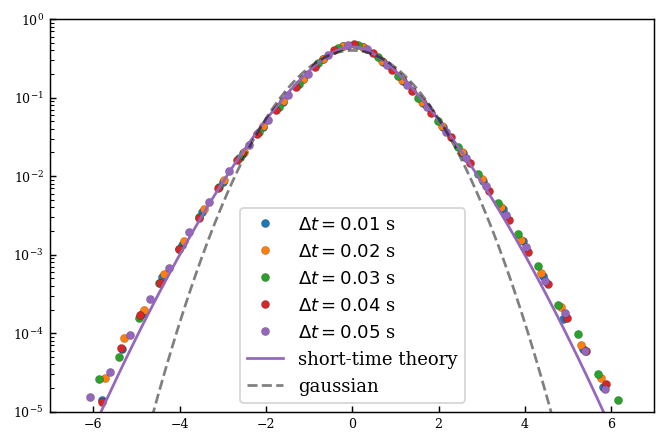

In [227]:
dataset["z"] = z_dedrift
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure()
for n,i in enumerate([1,2,3,4,5]):
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
    Dezs = Dezs# - np.mean(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)
    hist = hist/np.trapz(hist,bins_center)
    dataset["pdf_Dz_short_t_{}".format(i)] = [bins_center/np.std(Dezs),hist/np.trapz(hist,bins_center/np.std(Dezs))] 
    plt.plot(bins_center/np.std(Dezs), hist/np.trapz(hist,bins_center/np.std(Dezs)), ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]), markersize = 9,color = color[n])
    if i == 5:
        Dz_th = np.linspace(2*np.min(Dezs), 2*np.max(Dezs),1000)
        popt, pcov = curve_fit(gauss_function,bins_center/np.std(Dezs), hist/np.trapz(hist,bins_center/np.std(Dezs)), p0 = [1, 1, 1])
        PPP = P_Dz_short_time(Dz_th,time[i],B,ld,lb,offset=0)
        
        z_gauss = np.linspace(-10,10,1000)


z_gauss = np.linspace(-10,10,1000)
popt =  [1,0,1]
gauss = gauss_function(z_gauss, *popt)
gauss = gauss / np.trapz(gauss,z_gauss)
plt.semilogy(Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs)),color = color[n],label="short-time theory")
dataset["pdf_Dz_short_th_t_{}".format(i)] = [Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs))]
plt.plot(z_gauss, gauss, markersize = 4, color = "k",alpha=0.5,linestyle="--", label = "gaussian")
dataset["gaussian_short_timetheory_z"] = [z_gauss, gauss]
plt.legend()
ax = plt.gca()
ax.set_ylim([1e-5,1])
ax.set_xlim([-7,+7])

plt.savefig("pdf_Delta_z_tps_courts_normalized.pdf")

In [228]:
popt

[1, 0, 1]

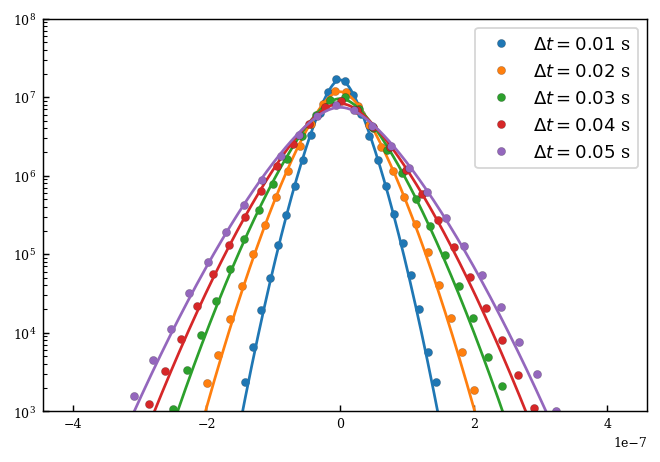

In [229]:
dataset["z"] = z_dedrift
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure()
for n,i in enumerate([1,2,3,4,5]):
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:]) * 1e-6
    Dezs = Dezs# - np.mean(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 30)
    hist = hist/np.trapz(hist,bins_center)
    plt.plot(bins_center, hist, ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]), markersize = 9,color = color[n])
    Dz_th = np.linspace(np.min(Dezs), np.max(Dezs),1000)
    PPP = P_Dz_short_time(Dz_th,time[i],B,ld,lb,offset=0)
    plt.semilogy(Dz_th,PPP,color = color[n])
    #if i == 1:
    #    popt, pcov = curve_fit(gauss_function, bins_center, hist, p0 = [1, np.mean(Dezs), np.std(Dezs)])
    

#plt.plot(bins_center, gauss_function(bins_center, *popt), markersize = 4, color = "k",alpha=0.5,linestyle="--", label = "gaussian")
plt.legend()
ax = plt.gca()
ax.set_ylim([1e3,1e8])
plt.savefig("pdf_Delta_z_tps_courts.pdf")

# Distribution x and y

In [230]:
def c_P_Dx(B,ld,lb):
    z = np.linspace(1e-9,15e-6,1000)
    
    P_D = Dx_z(z) * Do * P_b_off(z, 0, B, ld, lb)
    
    return Dx_z(z) * Do, P_D/np.trapz(P_D,z)

def _P_Dx_short_time(Dx,Dt,B,ld,lb):

    D_x, P_D = c_P_Dx(B,ld,lb)
    
    P = np.trapz(P_D / np.sqrt(4 * np.pi * D_x * Dt) * np.exp(- Dx**2 / (4 * D_x*Dt)),D_x)
    
    return P

def P_Dx_short_time(Dx,Dt,B,ld,lb):

    
    P = [_P_Dx_short_time(i,Dt,B,ld,lb) for i in Dx]
    P = np.array(P)
    P = P / np.trapz(P,Dx)
    
    return P

P_Dx_short_time([1e-8,1e-9],time[4],B,ld,lb)

array([-1.10600713e+08, -1.11621509e+08])

Text(0, 0.5, '$P(\\Delta x/std(\\Delta x))$')

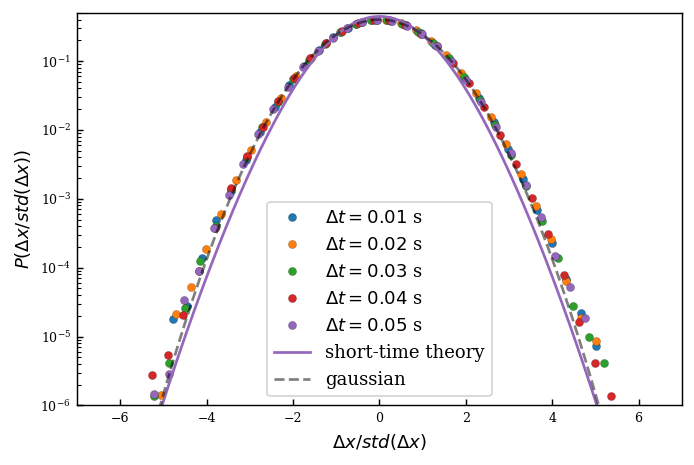

In [231]:
dataset["x"] = x
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure()
for n,i in enumerate([1,2,3,4,5]):
    Dexs = (dataset["x"][0:-i] - dataset["x"][i:]) * 1e-6
    hist, bins_center = pdf(Dexs[~np.isnan(Dexs)], bins = 30)
    hist = hist/np.trapz(hist,bins_center)
    dataset["pdf_Dx_short_t_{}".format(i)] = [bins_center/np.std(Dexs),hist/np.trapz(hist,bins_center/np.std(Dexs))] 
    plt.plot(bins_center/np.std(Dexs), hist/np.trapz(hist,bins_center/np.std(Dexs)), ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]), markersize = 9,color = color[n])
    if i == 5:
        Dx_th = np.linspace(2*np.min(Dexs), 2*np.max(Dexs),1000)
        popt, pcov = curve_fit(gauss_function,bins_center/np.std(Dexs), hist/np.trapz(hist,bins_center/np.std(Dexs)), p0 = [1, 1, 1])
        PPP = P_Dx_short_time(Dx_th,time[i],B,ld,lb)
        
        x_gauss = np.linspace(-10,10,1000)

popt =  [1,0,1]
gauss = gauss_function(z_gauss, *popt)
gauss = gauss / np.trapz(gauss,z_gauss)
plt.semilogy(Dx_th/np.std(Dexs),PPP/np.trapz(PPP,Dx_th/np.std(Dexs)),color = color[n],label="short-time theory")
#dataset["pdf_Dz_short_th_t_{}".format(i)] = [Dz_th/np.std(Dezs),PPP/np.trapz(PPP,Dz_th/np.std(Dezs))]
plt.semilogy(x_gauss, gauss, markersize = 4, color = "k",alpha=0.5,linestyle="--", label = "gaussian")
dataset["gaussianx_short_timetheory"] = [x_gauss, gauss]
plt.legend()
ax = plt.gca()
ax.set_ylim([1e-6,0.5])
ax.set_xlim([-7,+7])
dataset["pdf_Dx_short_th_t_{}".format(i)] = [Dx_th/np.std(Dexs),PPP/np.trapz(PPP,Dx_th/np.std(Dexs))]

plt.xlabel("$\Delta x/std( \Delta x)$")
plt.ylabel("$P(\Delta x/std(\Delta x))$")
#plt.savefig("pdf_Delta_z_tps_courts_normalized.pdf")

In [232]:
popt

[1, 0, 1]

# Premier moment

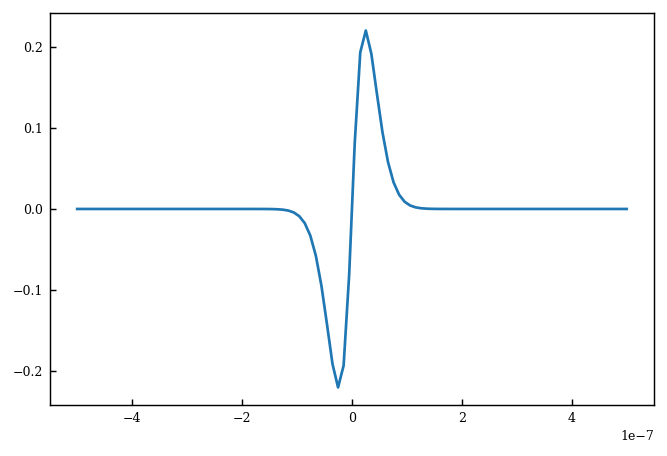

In [233]:
Dz_th = np.linspace(-5e-7,5e-7,100)


plt.plot(Dz_th,Dz_th * P_Dz_short_time(Dz_th,time[1],B,ld,lb))

In [234]:
time[1]

0.01

In [235]:
def moment1_th_f(Dt,B,ld,lb):
    Dz_th = np.linspace(-5e-7,5e-7,100)
    

    moment = np.trapz(np.abs(Dz_th) * P_Dz_short_time(Dz_th,Dt,B,ld,lb), Dz_th)
    
    return moment
    

In [236]:
I = np.arange(1,10,1)

moment1_exp = MSDn(z*1e-6,I,1)


moment1_th = [moment1_th_f(i,B,ld,lb) for i in time[I]]


plt.plot(time[I], moment1_th, "o")
#plt.ylabel("$Kurtosis$ [a.u.]")
plt.xlabel("$\Delta t$ [s]")

plt.plot()

NameError: name 'MSDn' is not defined

In [237]:
moment1_th

NameError: name 'moment1_th' is not defined

In [238]:
plt.plot(time[I], moment1_th)


NameError: name 'moment1_th' is not defined

In [240]:
dataset["fitted_MSD_Plateau"] = Theoritical_Plateau(B,ld,lb)
dataset["Pb_th"] = P_b_off(dataset["x_pdf_z"], 0, B, ld, lb)
dataset["MSD_fit_x"] = f(dataset["MSD_time_tot"],dataset["D_para"],0)
dataset["MSD_fit_z"] = f(dataset["MSD_time_tot"],dataset["D_perp"],0)
dataset["z_D_th"] = z_th = np.linspace(10e-9,10e-6,100)
dataset["z"] = z
#dataset["offset_B"] = offset_B
dataset["err_long_t"] = err_long_t
dataset["bins_centers_long_t"] = bins_centers_long_t
dataset["Pdeltaz_long_th"] = Pdeltaz_long(bins_centers_long_t*1e-6, B, ld, lb)
dataset["D_x_th"] = Dx_z_off(z_th,0)
dataset["D_z_th"] = Dz_z(z_th,0)
dataset["offset_diffusion"] = offset_diffusion
dataset["Do"] = Do

C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/2484670554.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad = 0.1)
C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/2484670554.py:201: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("graphe.pdf",dpi=600)
C:\Users\maxim\AppData\Local\Temp/ipykernel_20208/2484670554.py:201: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("graphe.pdf",dpi=600)
C:\Users\maxim\miniconda3\envs\cython\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


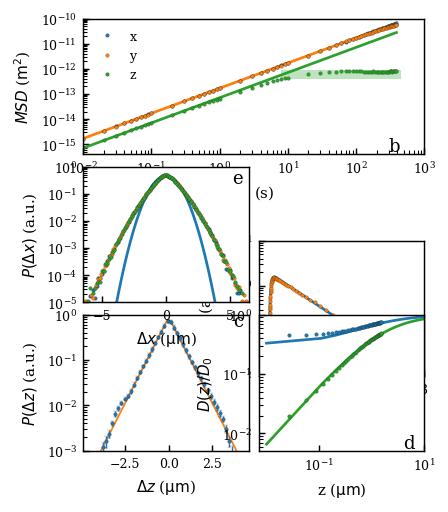

In [242]:
fig = plt.figure(figsize=(cm2inch(8.6), 1.3*cm2inch(8.6)),constrained_layout=True)
gs = fig.add_gridspec(6,6)


fig.add_subplot(gs[3:5,3:])


plt.plot(dataset["x_pdf_z"] * 1e6,dataset["Pb_th"])
plt.semilogy(dataset["x_pdf_z"] * 1e6 - 0,dataset["pdf_z"], "o", markersize = 2)

plt.xlabel("$z$ ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$P(z)$ (a.u.)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-2,10])
ax.set_xlim([-0.2,2])
plt.xticks([0,1,2,3])

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()



plt.text(0.9*xmax,1.1*ymin,'a')


##### MSD


fig.add_subplot(gs[0:2,0:])



plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_x"], color = "tab:orange")
plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_z"], color = "tab:green")

plt.loglog(dataset["MSD_time_tot"],dataset["MSD_x_tot"],"o", label = "x", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_y_tot"],"o", label = "y", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_z_tot"],"o", label = "z", markersize = 2)




# plateau

plateau = [dataset["fitted_MSD_Plateau"] for i in range(len(dataset["MSD_time_tot"]))]
plt.loglog(dataset["MSD_time_tot"][-40:], plateau[-40:], color = "tab:green", linewidth = 5, alpha = 0.3)
                               
    
##
ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax.set_xlim([1e-2,1e3])
ax.set_ylim([None,1e-10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.3*xmax,1.35*ymin,'b')


plt.ylabel("$MSD$ ($\mathrm{m^2}$)",fontsize = "small")
plt.xlabel("$\Delta$t (s)",fontsize = "small")

plt.legend(frameon = False,fontsize = "x-small",loc = "upper left")

##### PDF DZ long time



fig.add_subplot(gs[4:,0:3])

plt.errorbar(dataset["x_pdf_longtime"]*1e6,dataset["pdf_longtime"],yerr=err_long_t,barsabove=True,linewidth = 0.8, label = "experimental pdf",marker="o", markersize=2,capsize = 1,linestyle="")
#plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)
plt.semilogy(dataset["bins_centers_long_t"],dataset["Pdeltaz_long_th"], linewidth = 1, zorder=-1)


plt.ylabel("$P(\Delta z)$ (a.u.)",fontsize = "small")
plt.xlabel("$\Delta z$ ($\mathrm{\mu m}$)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-3,1])
#ax.set_xlim([None,1e-10])

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.55*ymax,'c')


#### VISCOSITY

z_th = np.linspace(10e-9,10e-6,100)
fig.add_subplot(gs[4:,3:])

#plt.errorbar(z_D_para_fit, D_para_fit/Do, yerr = err_d_para_fit/Do, linewidth = 3, marker = "x", linestyle = "",color = "tab:red", label = "$D_ \\parallel$")
plt.loglog(z_th*1e6, dataset["D_x_th"], color = "tab:blue")
plt.plot(dataset["z_D_yacine"]*1e6 - offset_diffusion, dataset["z_D_x_yacine"] / Do, marker = "o", linestyle = "",color = "tab:blue",label =  "$D_\\parallel$", markersize = 2)



#plt.errorbar(bins_center_pdf_z[:-1], Dz[:]/Do, yerr=err[:]/Do, linewidth = 3, marker = "o", linestyle = "",color = "tab:red",label =  "$D_ \\bot$")
plt.semilogx(z_th*1e6, dataset["D_z_th"], color = "tab:green")
plt.plot(dataset["z_D_yacine"]*1e6 - offset_diffusion, dataset["z_D_z_yacine"] / Do, marker = "o", linestyle = "",color = "tab:green",label =  "$D_ \\bot$", markersize = 2)


ax = plt.gca()
ax.set_ylim([None,1])
ax.set_xlim([None,10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.4*xmax,1.1*ymin,'d')


#plt.legend(frameon = False,fontsize = "x-small",loc="lower center")
plt.xlabel("z ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$D (z)/ D_\mathrm{0}$",fontsize = "small")



#### Inset

# Inset

#left, bottom, width, height = [0.26, 0.2, 0.15, 0.11]
#ax2 = fig.add_axes([left, bottom, width, height])
fig.add_subplot(gs[2:4,0:3])
I = [1, 4, 5]

for i in I:
    
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:])
    Dezs = Dezs / np.nanstd(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 100)
    hist = hist/np.trapz(hist,bins_center)
    
    if i == I[0]:
        popt, pcov = curve_fit(gauss_function, bins_center, hist, p0 = [1, np.mean(hist), np.std(hist)])
        plt.plot(bins_center, gauss_function(bins_center, *popt), markersize = 4)#, label = "fit at t = {:.2f} s".format(time[i]))
        plt.plot(bins_center, hist, ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]),color = "tab:blue", markersize = 4)
        plt
        continue
    plt.semilogy(bins_center, hist, ".",label = " $\\Delta t = {:.2f}$ s".format(time[i]), markersize = 4)

ax = plt.gca()
ax.set_ylim([1e-5,1])
ax.set_xlim([-6.5,6.5])
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

#for axis in [ax.xaxis, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())

#plt.legend(fontsize = "xx-small", frameon = False)
plt.ylabel("$P(\Delta x)$ (a.u.)", fontsize = "small")
plt.xlabel("$\Delta x$ ($\mathrm{\mu m}$)", fontsize = "small")


#plt.subplot(3,3,2)
#plt.subplot(3,3,5)
#plt.subplot(3,3,8)

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.25*ymax,'e')

plt.tight_layout(pad = 0.1)

plt.savefig("graphe.pdf",dpi=600)

In [243]:
offset_diffusion

-0.006937529279646558

# Measure of the drift

In [244]:
offset_diffusion

-0.006937529279646558

In [245]:
z_0offset = z_dedrift + offset_diffusion

def logarithmic_hist(data,begin,stop,num = 50,base = 2):
    
    if begin == 0:
        beg = stop/num
        bins = np.logspace(np.log(beg)/np.log(base), np.log(stop)/np.log(base), num-1, base=base)
        widths = (bins[1:] - bins[:-1])
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0],bins))
        widths = (bins[1:] - bins[:-1])
    
    else:
        bins = np.logspace(np.log(begin)/np.log(base), np.log(stop)/np.log(base), num, base=base)
        widths = (bins[1:] - bins[:-1])
    
    hist = np.histogram(data, bins=bins,density=True)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1])/2
    
    return bins_center,widths, hist



bins_center_pdf_z,widths,hist = logarithmic_hist(z_0offset, 0.031, 4, num = 35,base=2)
#hist,bins_center_pdf_z = pdf(z_0offset[z_0offset < 2.5],  bins = 150)


In [246]:
def vzz(times=[1]):
    
    # We frist get all the different variables of the problem
    z = z_0offset* 1e-6
    Y = bins_center_pdf_z * 1e-6
    z_z = z 

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.      
    # We initialize the variable used to store the results.
    # For the diffusion coefficient itself.
    vz = np.zeros((len(times), len(Y[:-1])))

    # For the error
    errvz = np.zeros((len(times), len(Y[:-1])))
    
    
    for n, i in enumerate(times):
        
        # Conpute the Delta x = x(Dt + t) - x(t) for given Dt -- same over y
        Dzs = z_z[i:] - z_z[0:-i]
        
        # Now for each z-bin we are going to measure the diffusion coefficient.
        
        for m in range(len(Y)-1):
            
            # We take the Dx corresponding the actual bin 
            dz = Dzs[(z[range(len(Dzs))] > Y[m]) & (z[range(len(Dzs))] < Y[m+1])]
            
            
            vz[n,m] = np.mean(dz)/(i/fps)
            #errvz[n,m] = (np.std(dz))/(i/fps)
            errvz[n,m] = len(dz)
    err_vz = np.nanmean(errvz, axis=0)
    vz = np.nanmean(vz, axis=0)
          
    return vz, err_vz

In [247]:

vz2,err2 = vzz(np.arange(1,3))


In [248]:
err2

array([ 10091. ,  12952. ,  16416. ,  20295. ,  24797. ,  29770. ,
        35511. ,  40383. ,  46358. ,  52526. ,  58193. ,  64863. ,
        71727. ,  77839. ,  83978. ,  89427.5,  97379. , 103317. ,
       108321. , 109109. , 109143. , 108752. , 106296. ,  99732. ,
        87751. ,  73491. ,  62823. ,  51128. ,  38569. ,  29451. ,
        19562. ,  14831. ,   7545. ])

In [249]:


def F_fictif(z):
    F = 4e-21 * (42*r*z*z + 24*r*r*z + 4*r*r*r)/(36*(z**4) + 66*r*(z**3) + 30*r*r*z*z + 4*(r**3)*z)
    
    return F

z_F_exp = (bins_center_pdf_z[:-1] )*1e-6

#F_exp1 = 6 * np.pi  * 0.001 * r * vz1/ Dz_z(z_F_exp, 0)
#F_err1 = 6 * np.pi  * 0.001 * r * err1/ Dz_z(z_F_exp, 0)
F_exp2 = 6 * np.pi  * 0.001 * r * vz2/ Dz_z(z_F_exp, 0)
F_err2 = 6 * np.pi  * 0.001 * r * err2/ Dz_z(z_F_exp, 0)
F_err2 = np.sqrt(4*4e-21*(6*np.pi*0.001/ Dz_z(z_F_exp, 0)*r)/(err2/fps))

#F_exp1 = F_exp1 - F_fictif(bins_center_pdf_z[:-1]*1e-6)
F_exp2 = F_exp2

#plt.semilogx(bins_center_pdf_z[:-1],F_exp1)
#plt.semilogx(bins_center_pdf_z[:-1],F_exp2)



In [250]:
err2

array([ 10091. ,  12952. ,  16416. ,  20295. ,  24797. ,  29770. ,
        35511. ,  40383. ,  46358. ,  52526. ,  58193. ,  64863. ,
        71727. ,  77839. ,  83978. ,  89427.5,  97379. , 103317. ,
       108321. , 109109. , 109143. , 108752. , 106296. ,  99732. ,
        87751. ,  73491. ,  62823. ,  51128. ,  38569. ,  29451. ,
        19562. ,  14831. ,   7545. ])

In [251]:
F_exp2 = 6 * np.pi  * 0.001 * r * vz2/ Dz_z(z_F_exp, 0)

F_exp2 = F_exp2 #- F_fictif(z_F_exp)

Text(0.5, 0, '$Height$ $z$ $(\\mathrm{\\mu m})$')

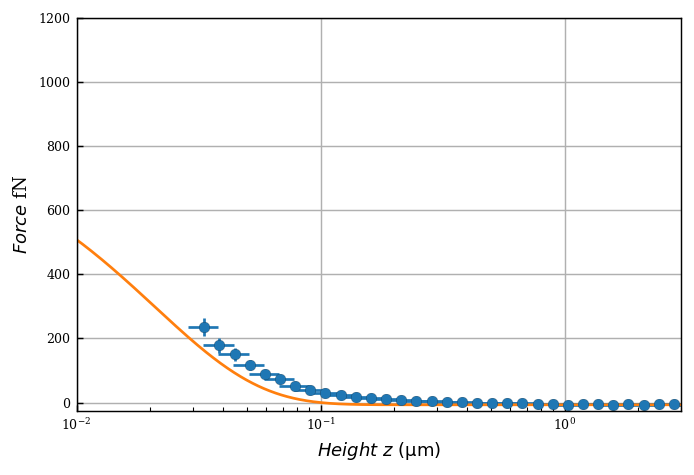

In [252]:

z_F_th = np.linspace(1e-9,3e-6,10000)

F_th = 4e-21 * ( B/(ld*1e-9) * np.exp(- z_F_th/(ld*1e-9)) - 1/(lb*1e-9) ) # - 0.01*4e-21*r/z_F_th**2 / 6

def Force_th(z,B,ld,lb):
    return 4e-21 * ( B/(ld*1e-9) * np.exp(- z/(ld*1e-9)) - 1/(lb*1e-9))

dataset["z_Force"] = z_F_exp
dataset["Force"] = F_exp2
dataset["err_Force"] = F_err2
dataset["x_err_Force"] = widths[:-1]

dataset["z_Force_th"] = z_F_th
dataset["Force_th"] = F_th
#plt.errorbar(z_F_exp*1e6, F_exp1*1e15,yerr=F_err1*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_exp2*1e15,yerr=2*F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
#plt.plot(z_F_exp*1e6,F_exp2*1e15,"o")

plt.semilogx(z_F_th*1e6,F_th*1e15)

plt.grid()
ax = plt.gca()
ax.set_ylim([-25,1200])
ax.set_xlim([0.1e-1,3])
plt.ylabel("$Force$ fN")
plt.xlabel("$Height$ $z$ $(\\mathrm{\mu m})$")

In [253]:
Fg = -4e-21/(lb*1e-9)
print("Fg = {}".format(Fg))
Fg_exp = np.mean(F_exp2[-100:-2])
Fg_std = np.std(F_exp2[-100:-2])

print("Fg_exp = {} $\p {}".format(Fg_exp,Fg_std))


Fg = -7.01733460658024e-15
Fg_exp = 3.2171288732104577e-14 $\p 5.998075333428213e-14


In [254]:
stop

NameError: name 'stop' is not defined

In [ ]:
F_exp2[-10:]

In [ ]:


z_F_th = np.linspace(1e-9,3e-6,10000)

F_th = 4e-21 * ( B/(ld*1e-9) * np.exp(- z_F_th/(ld*1e-9)) - 1/(lb*1e-9) ) # - 0.01*4e-21*r/z_F_th**2 / 6

def Force_th(z,B,ld,lb):
    return 4e-21 * ( B/(ld*1e-9) * np.exp(- z/(ld*1e-9)) - 1/(lb*1e-9))

dataset["z_Force"] = z_F_exp
dataset["Force"] = F_exp2
dataset["err_Force"] = F_err2
dataset["x_err_Force"] = widths[:-1]

dataset["z_Force_th"] = z_F_th
dataset["Force_th"] = F_th
#plt.errorbar(z_F_exp*1e6, F_exp1*1e15,yerr=F_err1*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_exp2*1e15-Fg*1e15,yerr=2*F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
#plt.plot(z_F_exp*1e6,F_exp2*1e15,"o")

plt.semilogy(z_F_th*1e6,F_th*1e15-Fg*1e15)

plt.grid()
ax = plt.gca()
ax.set_ylim([1e-1,1000])
ax.set_xlim([0.1e-1,1])
plt.ylabel("$Force$ fN")
plt.xlabel("$Height$ $z$ $(\\mathrm{\mu m})$")

In [ ]:
4e-21/(lb*1e-9)

In [255]:
savemat("data_graphs.mat",dataset)

In [ ]:
dataset["err_Force"]
stop

## Redo Multifit

In [ ]:
dataset["D_para"] = mean_Dx
dataset["D_perp"] = mean_Dz


#minimizer with the log 
def minimizer2(x, *args):
    #f linear function for the MSDs
    data = dataset
    #functions = [f, Pdeltaz_long, minimizer_diffusion_coeff, P_b_off, Dx_z_off]
    ld = x[0]
    lb = x[1]
    B = x[2]
    #offset = x[3]
    #offset_2 = x[4]
    
  
    #chi MSDx 
    
    
    chi_mean_D_pdf = minimizer_diffusion_coeff(dataset["D_para"], dataset["D_perp"], 0, B, ld, lb)
    chi_MSD_plateau = minimize_plateau([B,ld,lb])
    
    E_longtime_pdf = (Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)) - np.log(data["pdf_longtime"])
    chi_longtime_pdf = np.mean((E_longtime_pdf[E_longtime_pdf > -np.inf] ** 2) / ((np.log(Pdeltaz_long(data["x_pdf_longtime"], B, ld, lb)))**2))
    
    E_chi_pdf_z = np.log(P_b_off(data["x_pdf_z"], 0, B, ld, lb)) - np.log(data["pdf_z"])
    chi_pdf_z = np.mean((E_chi_pdf_z[E_chi_pdf_z > -np.inf] ** 2) / (np.log(P_b_off(data["x_pdf_z"][E_chi_pdf_z > -np.inf], 0, B, ld, lb))**2))
    
    #E_D_z = np.log(Dz_z(data["x_fit_Dz"], offset)) - np.log(data["Dz"])
    #chi_D_z = np.mean(E_D_z[E_D_z > -np.inf] ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dz"], offset))**2)
    
    #E_D_x = np.log(Dx_z_off(data["x_fit_Dx"], offset)) - np.log(data["Dx"])
    #chi_D_x = np.mean(E_D_x[E_D_x > -np.inf]  ** 2) / np.mean(np.log(Dz_z(data["x_fit_Dx"], offset))**2)
    
    E_D_z = np.log(Dz_z(data["z_D_yacine"], offset)) - np.log(data["z_D_z_yacine"] / Do)
    chi_D_z = np.mean((E_D_z[E_D_z > -np.inf] ** 2) / (np.log(Dz_z(data["z_D_yacine"][E_D_z > -np.inf], offset))**2))
    
    E_D_x = np.log(Dx_z_off(data["z_D_yacine"], offset)) - np.log(data["z_D_x_yacine"] / Do)
    chi_D_x = np.mean((E_D_x[E_D_x > -np.inf]  ** 2) / (np.log(Dx_z_off(data["z_D_yacine"], offset))**2))
    
    chi_Dz_small_t = minimizer_Dz_small_t(B,ld,lb)
    
    E_F_z = np.nanmean(((Force_th(dataset["z_Force"], B,ld,lb) - (np.abs(dataset["Force"])))**2) /Force_th(dataset["z_Force"], B,ld,lb)**2)

    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x + chi_Dz_small_t + E_F_z
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  10*summ 
    
    E_F_z = np.nanmean((((np.abs(Force_th(dataset["z_Force"], B,ld,lb))) - (np.abs(dataset["Force"])))**2) /((np.log(np.abs(Force_th(dataset["z_Force"], B,ld,lb)))**2)) )

    
    summ = chi_mean_D_pdf + chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_Dz_small_t + E_F_z
    #summ = chi_MSD_plateau + chi_longtime_pdf + chi_pdf_z + chi_D_z + chi_D_x #+ chi_Dz_small_t
    #summ =  chi_D_z
    return  10*summ 
    
    

In [ ]:
lb

In [ ]:
x0 = [ld,lb,B]
minimizer2(x0)

In [ ]:
from scipy.optimize import leastsq

options={
    'maxc1or': 30, 
    'ftol': 2.220446049250313e-10, 
    'gtol': 1e-5, 
    'eps': 1e-08, 
    'maxfun': 15000, 
    'maxiter': 15000, 
    'maxls': 20, 
    'finite_diff_rel_step': None,
}


#bnds = ((0, 1), (0, 1), (0, 30), (1, None), (1, None),(1, None),(10, 20),(40, 200),(400, 600),(0, 0.1))
bnds = ((10,100),(400,600),(1,10),(0.05),(0,0.05))

res = minimize(minimizer2,
               x0,
               method = "BFGS",
               tol = 0.1e-4,
              )



#res = leastsq(minimizer, x0)


In [ ]:
res

In [ ]:


res.x
results = {
    "ld":res.x[0],
    "lb":res.x[1],
    "B":res.x[2],
    #"offset_diffusion":res.x[3],
    #"offset_boltzmann":res.x[4], 
}

results

In [ ]:
ld = res.x[0]
lb = res.x[1]
B = res.x[2]
#offset_diffusion = res.x[3]
#offset_B = res.x[4]

In [ ]:

z_F_th = np.linspace(1e-9,3e-6,10000)

F_th = 4e-21 * ( B/(ld*1e-9) * np.exp(- z_F_th/(ld*1e-9)) - 1/(lb*1e-9) ) # - 0.01*4e-21*r/z_F_th**2 / 6

def Force_th(z,B,ld,lb):
    return 4e-21 * ( B/(ld*1e-9) * np.exp(- z/(ld*1e-9)) - 1/(lb*1e-9))


#plt.errorbar(z_F_exp*1e6, F_exp1*1e15,yerr=F_err1*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_exp2*1e15,yerr=0*F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
#plt.plot(z_F_exp*1e6,F_exp2*1e15,"o")

plt.semilogx(z_F_th*1e6,F_th*1e15)

plt.grid()
ax = plt.gca()
ax.set_ylim([-25,700])
ax.set_xlim([0.1e-1,3])
plt.ylabel("$Force$ fN")
plt.xlabel("$Height$ $z$ $(\\mathrm{\mu m})$")

In [ ]:
fig = plt.figure(figsize=(cm2inch(8.6), 1.3*cm2inch(8.6)),constrained_layout=True)
gs = fig.add_gridspec(6,6)


fig.add_subplot(gs[3:5,3:])

plt.plot(dataset["x_pdf_z"] * 1e6,P_b_off(dataset["x_pdf_z"], 0, B, ld, lb))
plt.semilogy(dataset["x_pdf_z"] * 1e6,dataset["pdf_z"], "o", markersize = 2)

plt.xlabel("$z$ ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$P(z)$ (a.u.)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-3,10])
ax.set_xlim([-0.2,3])
plt.xticks([0,1,2,3])

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()



plt.text(0.9*xmax,1.1*ymin,'a')


##### MSD


fig.add_subplot(gs[0:2,0:])

dataset["MSD_fit_x"] = f(dataset["MSD_time_tot"],dataset["D_para"],0)
dataset["MSD_fit_z"] = f(dataset["MSD_time_tot"],dataset["D_perp"],0)

plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_x"], color = "tab:orange")
plt.loglog(dataset["MSD_time_tot"], dataset["MSD_fit_z"], color = "tab:green")

plt.loglog(dataset["MSD_time_tot"],dataset["MSD_x_tot"],"o", label = "x", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_y_tot"],"o", label = "y", markersize = 2)
plt.loglog(dataset["MSD_time_tot"],dataset["MSD_z_tot"],"o", label = "z", markersize = 2)




# plateau
dataset["fitted_MSD_Plateau"] = Theoritical_Plateau(B,ld,lb)

plateau = [dataset["fitted_MSD_Plateau"] for i in range(len(dataset["MSD_time_tot"]))]
plt.loglog(dataset["MSD_time_tot"][-40:], plateau[-40:], color = "tab:green", linewidth = 5, alpha = 0.3)
                               
    
##
ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax.set_xlim([1e-2,1e3])
ax.set_ylim([None,1e-10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.3*xmax,1.35*ymin,'b')


plt.ylabel("$MSD$ ($\mathrm{m^2}$)",fontsize = "small")
plt.xlabel("$\Delta$t (s)",fontsize = "small")

plt.legend(frameon = False,fontsize = "x-small",loc = "upper left")

##### PDF DZ long time



fig.add_subplot(gs[4:,0:3])

plt.errorbar(dataset["x_pdf_longtime"]*1e6,dataset["pdf_longtime"],yerr=err_long_t,barsabove=True,linewidth = 0.8, label = "experimental pdf",marker="o", markersize=2,capsize = 1,linestyle="")
#plt.fill_between(bins_centers_long_t, pdf_long_t-err_long_t, pdf_long_t+err_long_t, alpha = 0.3)
plt.semilogy(bins_centers_long_t,Pdeltaz_long(bins_centers_long_t*1e-6, B, ld, lb), linewidth = 1, zorder=-1)


plt.ylabel("$P(\Delta z)$ (a.u.)",fontsize = "small")
plt.xlabel("$\Delta z$ ($\mathrm{\mu m}$)",fontsize = "small")

ax = plt.gca()
ax.set_ylim([1e-3,1])
#ax.set_xlim([None,1e-10])

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.55*ymax,'c')


#### VISCOSITY

z_th = np.linspace(10e-9,10e-6,100)
dataset["z_D_th"] = z_th
fig.add_subplot(gs[4:,3:])

#plt.errorbar(z_D_para_fit, D_para_fit/Do, yerr = err_d_para_fit/Do, linewidth = 3, marker = "x", linestyle = "",color = "tab:red", label = "$D_ \\parallel$")
dataset["D_x_th"] = Dx_z_off(z_th,0)
plt.loglog(z_th*1e6, dataset["D_x_th"], color = "tab:blue")
plt.plot(dataset["z_D_yacine"]*1e6 - dataset["offset_diffusion"], dataset["z_D_x_yacine"] / Do, marker = "o", linestyle = "",color = "tab:blue",label =  "$D_\\parallel$", markersize = 2)


dataset["D_z_th"] = Dz_z(z_th,0)

#plt.errorbar(bins_center_pdf_z[:-1], Dz[:]/Do, yerr=err[:]/Do, linewidth = 3, marker = "o", linestyle = "",color = "tab:red",label =  "$D_ \\bot$")
plt.semilogx(z_th*1e6, dataset["D_z_th"], color = "tab:green")
plt.plot(dataset["z_D_yacine"]*1e6 - offset_diffusion, dataset["z_D_z_yacine"] / Do, marker = "o", linestyle = "",color = "tab:green",label =  "$D_ \\bot$", markersize = 2)


ax = plt.gca()
ax.set_ylim([None,1])
ax.set_xlim([None,10])


ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.4*xmax,1.1*ymin,'d')


#plt.legend(frameon = False,fontsize = "x-small",loc="lower center")
plt.xlabel("z ($\mathrm{\mu m}$)",fontsize = "small")
plt.ylabel("$D (z)/ D_\mathrm{0}$",fontsize = "small")



#### Inset

# Inset

#left, bottom, width, height = [0.26, 0.2, 0.15, 0.11]
#ax2 = fig.add_axes([left, bottom, width, height])
fig.add_subplot(gs[2:4,0:3])
dataset["z"]=z
I = [1, 4, 5]

for i in I:
    
    Dezs = (dataset["z"][0:-i] - dataset["z"][i:])
    Dezs = Dezs / np.nanstd(Dezs)
    hist, bins_center = pdf(Dezs[~np.isnan(Dezs)], bins = 100)
    hist = hist/np.trapz(hist,bins_center)
    
    if i == I[0]:
        popt, pcov = curve_fit(gauss_function, bins_center, hist, p0 = [1, np.mean(hist), np.std(hist)])
        plt.plot(bins_center, gauss_function(bins_center, *popt), markersize = 4)#, label = "fit at t = {:.2f} s".format(time[i]))
        plt.plot(bins_center, hist, ".",label = "$ \\Delta t = {:.2f}$ s".format(time[i]),color = "tab:blue", markersize = 4)
        plt
        continue
    plt.semilogy(bins_center, hist, ".",label = " $\\Delta t = {:.2f}$ s".format(time[i]), markersize = 4)

ax = plt.gca()
ax.set_ylim([1e-5,1])
ax.set_xlim([-6.5,6.5])
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

#for axis in [ax.xaxis, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())

#plt.legend(fontsize = "xx-small", frameon = False)
plt.ylabel("$P(\Delta x)$ (a.u.)", fontsize = "small")
plt.xlabel("$\Delta x$ ($\mathrm{\mu m}$)", fontsize = "small")


#plt.subplot(3,3,2)
#plt.subplot(3,3,5)
#plt.subplot(3,3,8)

ymin, ymax = fig.gca().get_ylim()
xmin, xmax = fig.gca().get_xlim()

plt.text(0.8*xmax,0.25*ymax,'e')

plt.tight_layout(pad = 0.1)

plt.savefig("graphe.pdf",dpi=600)

In [ ]:

z_F_th = np.linspace(1e-9,3e-6,10000)

F_th = 4e-21 * ( B/(ld*1e-9) * np.exp(- z_F_th/(ld*1e-9)) - 1/(lb*1e-9) ) # - 0.01*4e-21*r/z_F_th**2 / 6

def Force_th(z,B,ld,lb):
    return 4e-21 * ( B/(ld*1e-9) * np.exp(- z/(ld*1e-9)) - 1/(lb*1e-9))


#plt.errorbar(z_F_exp*1e6, F_exp1*1e15,yerr=F_err1*1e15,xerr=widths[:-1], linestyle="", marker="o")
plt.errorbar(z_F_exp*1e6, F_exp2*1e15,yerr=0*F_err2*1e15,xerr=widths[:-1], linestyle="", marker="o")
#plt.plot(z_F_exp*1e6,F_exp2*1e15,"o")

plt.semilogx(z_F_th*1e6,F_th*1e15)

plt.grid()
ax = plt.gca()
ax.set_ylim([-25,1000])
ax.set_xlim([0.1e-1,3])
plt.ylabel("$Force$ fN")
plt.xlabel("$Height$ $z$ $(\\mathrm{\mu m})$")

## Comparizzzzon to pdf

In [ ]:
from scipy.interpolate import UnivariateSpline
from scipy.misc import derivative

x, y = pdf(z_0offset[z_0offset < 2.5]*1e-6,  bins = 30)

x = -np.log(x);x = x - np.min(x)

f = UnivariateSpline(y,x)
f.set_smoothing_factor(0)

In [ ]:
x_dev = np.linspace(1e-9,1e-6,1000)

F_expexp = - derivative(f,x_dev,dx=1e-10) * 4e-21

In [ ]:
bins = np.cumsum(widths[::-1])
widths2 = (bins[1:] - bins[:-1])

# On the n - r measurement

In [ ]:
#stop

n_r = np.fromfile("/home/maxime/Documents/Data_Brownian_paper/data/find_nrfit_result_dur_27052020_n_r_fix_0p0513_wav_532.dat")
n_r = n_r.reshape(len(n_r)//10,10)
r = n_r[:,3]
n = n_r[:,4]

In [ ]:
H, xedges, yedges = np.histogram2d(n, r, bins=100)
H = H.T  # Let each row list bins with common y range.

In [ ]:
plt.hist2d(r,n, bins = 150)
plt.ylabel("n")
plt.xlabel("r [$\mathrm{\mu m}$]")

In [ ]:
plt.hist2d(r[(r>1.42) & (r<1.48)],n[(r>1.42) & (r<1.48)], bins = 150)
plt.ylabel("n")
plt.xlabel("r [$\mathrm{\mu m}$]")

In [ ]:
r[(r>1.4) & (r<1.5)]

In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.ticker as ticker

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = r[(r>1.445) & (r<1.465)]
y = n[(r>1.445) & (r<1.465)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
f = f/np.max(f)



In [ ]:
fig = plt.figure()
fig.subplots_adjust(left=0.16, bottom=.20, right=.99, top=.99)
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k', levels=6)
# Label plot
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.3f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.3f'))
ax.clabel(cset, inline=1, fontsize=4, fmt="%1.1f")
plt.scatter(xx[np.where(f == 1)],yy[np.where(f == 1)], color = "red", marker="+")
ax.set_xlabel("r [$\mathrm{\mu m}$]")
ax.set_ylabel("n")
#plt.title("KDE r n")
fig.set_size_inches(cm2inch(8.6), cm2inch(8.6/1.618))
fig.savefig('KDErn.pdf')
#pl.show()

In [ ]:
print(" n determined with : mu={0}, sigma={1}".format(np.mean(yy[np.where(f > 0.1)]), np.std(yy[np.where(f > 0.1)])))
print(" r determined with : mu={0}, sigma={1}".format(np.mean(xx[np.where(f > 0.1)]), np.std(xx[np.where(f > 0.1)])))


In [ ]:
1e-3 / (3600*24*9)

In [ ]:
min(data["x_pdf_z"])

In [ ]:
5*4e-21/70e-9*1e12

In [ ]:
data

In [ ]:
print(plt.style.available)

In [ ]:
dataset["z"]=z

In [ ]:
vz,verr = vzz()

In [ ]:


    
plt.plot(z_z[2:-2],Dzs, "o")

In [ ]:
z = z_0offset* 1e-6
Y = bins_center_pdf_z * 1e-6
z_z = z 

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.  
Dzs = (z_z[2:] - z_z[:-2])/(2/fps)

plt.hist2d(z_z[1:-1],Dzs, bins = 300)
plt.ylabel("v")
plt.xlabel("z")
ax = plt.gca()
ax.set_ylim([-2e-6,+2e-6])
ax.set_xlim([0,1e-6])

In [ ]:
z = z_0offset* 1e-6
Y = bins_center_pdf_z * 1e-6
z_z = z 

    # We choose over wich time we want to comput the diffusion coefficient
    # Theoritically it should be the same for each time.  
Dzs = (z_z[2:] - z_z[:-2])/(2/fps)

plt.hist2d(z_z[:-2],Dzs, bins  = 300)
plt.ylabel("v")
plt.xlabel("z")
ax = plt.gca()
ax.set_ylim([-2e-6,+2e-6])
ax.set_xlim([0,1e-6])

In [ ]:
plt.plot(x,y)

In [ ]:
plt.plot(y)

In [ ]:
len(x)

In [ ]:
np.diff(z_F_exp)[0]

In [ ]:
dataset["Dz"][0]*Do

In [ ]:
# Dt = widthbin**2 
t_max_calcul_Force = np.diff(z_F_exp)[0]**2/dataset["Dz"][0]/Do

In [ ]:
t_max_calcul_Force

In [ ]:
time[2]

In [ ]:
dataset

In [ ]:
r

In [ ]:
dataset["r"]

In [ ]:
1.3-1000

In [ ]:
lb_th = 4e-21 / (4/3*np.pi*50*(1.516e-6)**3*9.81)
lb_th

In [ ]:
lb_exp = 549.9823691986626 * 1e-9

In [ ]:
def lb_th(p):
    p = np.abs(p)
    return 4e-21 / (4/3*np.pi*(p)*(1.516e-6)**3*9.81)

In [ ]:
def porosity_finder(p):
    return (lb_exp+10e-9 - lb_th(p)) ** 2 / lb_exp

In [ ]:
(lb_exp - lb_th(51)) ** 2 / lb_exp

In [ ]:
lb_th(50.5)

In [ ]:
res = minimize(porosity_finder,x0 = [51],tol = 1e-20)

In [ ]:
res

In [ ]:
def f_n(n):
    return (n**2 - 1) / (n**2 + 2)

n1 = 1.5983
n2 = 1
    
A = (1-0.0008) *(f_n(n1) - f_n(n2)) + f_n(n2)

In [ ]:
A

In [ ]:
np.sqrt()

In [ ]:
(f_n(1.58) - f_n(n2)) / (f_n(n1) - f_n(n2))

In [ ]:
0.0008423 * 100

In [ ]:
lb

In [ ]:
rs = np.array([r-6e-9, r+6e-9])
lbs = np.array([550e-9 - 1e-9,  550e-9 + 1e-9])

In [ ]:
rlb = [(a,b) for a in rs for b in lbs]

In [ ]:
f_rho = lambda r,lb : 4e-21 / (4/3 * np.pi * r**3 * 9.81 * lb) + 1000

In [ ]:
rhos = [f_rho(*a) for a in rlb]

In [ ]:
min(rhos)

In [ ]:
max(rhos)

In [ ]:
(min(rhos) + max(rhos)) / 2

In [ ]:
 (min(rhos) + max(rhos)) / 2 - min(rhos)